In [107]:
import pandas as pd
import spacy
import sqlite3
from sqlalchemy import create_engine

from spacytextblob.spacytextblob import SpacyTextBlob

from goodreads_book_scraper import get_listopia
from book_importer import BookImporter
from language_analysis import Book
from similarity import SimilarityChecker


# Data Pipeline

## Get a list of books from GoodReads

In [108]:

# Get the URL from the GoodReads website
best_books_ever_url = 'https://www.goodreads.com/list/show/1.Best_Books_Ever'
large_book_list_url = 'https://www.goodreads.com/list/show/952.1001_Books_You_Must_Read_Before_You_Die'
this_week_url = 'https://www.goodreads.com/book/most_read'

# Scrape the website and return lists of books, authors and average review
goodreads_list, author_list, review_list = get_listopia(this_week_url)



In [109]:
# Empty book_data list to store the books in
book_data = []

# Iterate through the book list and check if it is on Gutenberg
for count, book in enumerate(goodreads_list):
    file_path, book_id = BookImporter.gutendex(book, author_list[count])
    
    # Store the book in the book list
    book_data.append({'GutenbergID': book_id, 'Title': book, 'Author': author_list[count], 'Review': review_list[count], 'FilePath': file_path})


In [110]:
# Convert the book list into a pandas and check for missing values
book_data = pd.DataFrame(book_data)
book_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   GutenbergID  50 non-null     int64 
 1   Title        50 non-null     object
 2   Author       50 non-null     object
 3   Review       50 non-null     object
 4   FilePath     2 non-null      object
dtypes: int64(1), object(4)
memory usage: 2.1+ KB


### Remove Duplicates (if any)

In [111]:
# Check for duplicates
duplicates = book_data.duplicated()

duplicate_rows = book_data[duplicates]
print(duplicate_rows)

Empty DataFrame
Columns: [GutenbergID, Title, Author, Review, FilePath]
Index: []


In [112]:
# If there are any duplicate values (check by title and author), remove them
book_data = book_data.drop_duplicates(subset=['Title', 'Author'], keep='first')

In [113]:
# Check the dataframe
print(book_data.head())

   GutenbergID                                 Title           Author Review  \
0         6711  Tomorrow, and Tomorrow, and Tomorrow  Gabrielle Zevin   4.21   
1            0        Fourth Wing (The Empyrean, #1)   Rebecca Yarros   4.66   
2            0                  Lessons in Chemistry    Bonnie Garmus   4.32   
3            0                            Yellowface       R.F. Kuang   3.95   
4            0     The Housemaid (The Housemaid, #1)  Freida McFadden   4.35   

                                        FilePath  
0  data/Tomorrow,_and_Tomorrow,_and_Tomorrow.txt  
1                                           None  
2                                           None  
3                                           None  
4                                           None  


In [114]:
# Get a list of unique author names
author_list = book_data['Author'].unique()
author_list_df = pd.DataFrame({'Name': author_list})

print(author_list_df)

                   Name
0       Gabrielle Zevin
1        Rebecca Yarros
2         Bonnie Garmus
3            R.F. Kuang
4       Freida McFadden
5         Valerie Keogh
6   Taylor Jenkins Reid
7         Sarah J. Maas
8        Colleen Hoover
9         Rachel McLean
10           Lucy Score
11            Shari Low
12      Casey McQuiston
13        Hannah  Grace
14         Elsie Silver
15       Holly  Jackson
16          Lisa Jewell
17            Ana Huang
18          Delia Owens
19     Alex Michaelides
20        Richard Osman
21          Cara Hunter
22          Evie  Woods
23            L.J. Ross
24         Bella Mackie
25   Barbara Kingsolver
26          Emily Henry
27        Ali Hazelwood
28            Matt Haig
29     Jennette McCurdy
30     Maggie O'Farrell
31     Hanya Yanagihara


## Add data to SQL database

### Start up SQL

In [115]:
# Start the SQL database 
conn = sqlite3.connect('databases/book_repository.db')
cursor = conn.cursor()
engine = create_engine('sqlite:///databases/book_repository.db')


### Create the tables (Commented out after the first iteration)

In [116]:
# Create Authors table
with engine.begin() as connection:
    conn.execute('''
        CREATE TABLE IF NOT EXISTS Authors(
            AuthorID INTEGER PRIMARY KEY AUTOINCREMENT,
            Name VARCHAR
        )
    ''')

In [117]:
# Create Gutenberg table
with engine.begin() as connection:
    conn.execute('''
    CREATE TABLE IF NOT EXISTS Gutenberg(
        GutenbergID INTEGER PRIMARY KEY,
        FilePath VARCHAR
        );
    ''')
        # If there is not GutenbergID, it will reference this
    conn.execute('''
        INSERT OR IGNORE INTO Gutenberg (GutenbergID, FilePath)
        VALUES (0, 'Not Available')
        ''')

In [118]:
# Create Books table
with engine.begin() as connection:
    conn.execute('''
    CREATE TABLE IF NOT EXISTS Books(
        GutenbergID VARCHAR(7),
        Title VARCHAR,
        AuthorID INTEGER,
        Review DOUBLE,
        FOREIGN KEY (GutenbergID) REFERENCES Gutenberg(GutenbergID)
        FOREIGN KEY (AuthorID) REFERENCES Authors(AuthorID)
        );
''')


### Put the data in a temporary table

In [119]:
# Turn the books data into a temporary SQL table
book_data.to_sql('temp_books', conn, if_exists='replace', index=False)

50

In [120]:
# Turn the author list into a temporary SQL table
author_list_df.to_sql('temp_authors', conn, if_exists='replace', index=False)

32

In [121]:
# Insert the author names into the table, ignore repetitions
with engine.begin() as connection:
    conn.execute("""
        INSERT INTO Authors (Name)
        SELECT DISTINCT LOWER(t.Name)
        FROM temp_authors AS t
        LEFT JOIN Authors AS a ON LOWER(t.Name) = LOWER(a.Name)
        WHERE a.Name IS NULL
    """)

In [122]:
with engine.begin() as connection:
    conn.execute('''
        INSERT INTO Gutenberg (GutenbergID, FilePath)
        SELECT t.GutenbergID, t.FilePath
        FROM temp_books as t
        LEFT JOIN Gutenberg AS g ON t.GutenbergID = g.GutenbergID
        WHERE t.FilePath IS NOT NULL
          AND (g.GutenbergID IS NULL OR g.GutenbergID = 0)
    ''')

In [123]:
# Insert the rest of the Book data, with the foreign keys
with engine.begin() as connection:
    conn.execute('''
        INSERT INTO Books (GutenbergID, Title, AuthorID, Review)
        SELECT t.GutenbergID, t.Title, a.AuthorID, t.Review
        FROM temp_books AS t
        LEFT JOIN Authors AS a ON LOWER(t.Author) = LOWER(a.Name)
        LEFT JOIN Books AS b ON t.GutenbergID = b.GutenbergID
        WHERE b.GutenbergID IS NULL
    ''')

### Drop the temporary Table

In [124]:
# Drop the temporary tables
with engine.begin() as connection:
    conn.execute("DROP TABLE IF EXISTS temp_books")
    conn.execute('DROP TABLE IF EXISTS temp_authors')


In [125]:
# Check to see if the Data was inserted correctly
cursor.execute('''
    SELECT Books.Title, Authors.Name, Books.GutenbergID
    FROM Books
    LEFT OUTER JOIN Authors ON Books.AuthorID = Authors.AuthorID
''')

rows = cursor.fetchall()
for row in rows:
    print(f'{row[0]}: {row[1]}, {row[2]}')
print(len(rows))


The Hunger Games (The Hunger Games, #1): suzanne collins, 0
Harry Potter and the Order of the Phoenix (Harry Potter, #5): j.k. rowling, 0
Pride and Prejudice: jane austen, 1342
To Kill a Mockingbird: harper lee, 0
The Book Thief: markus zusak, 0
Twilight (The Twilight Saga, #1): stephenie meyer, 0
Animal Farm: george orwell, 0
J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings: j.r.r. tolkien, 0
The Chronicles of Narnia (Chronicles of Narnia, #1-7): c.s. lewis, 0
The Fault in Our Stars: john green, 0
Gone with the Wind: margaret mitchell, 0
The Giving Tree: shel silverstein, 0
The Picture of Dorian Gray: oscar wilde, 174
Wuthering Heights: emily brontë, 768
Harry Potter and the Philosopher’s Stone (Harry Potter, #1): j.k. rowling, 0
The Perks of Being a Wallflower: stephen chbosky, 0
Jane Eyre: charlotte brontë, 1260
The Da Vinci Code (Robert Langdon, #2): dan brown, 0
The Great Gatsby: f. scott fitzgerald, 64317
The Little Prince: antoine de saint-exupéry, 0
Alice's

In [126]:
# Check if the Gutenberg table was inserted correctly
cursor.execute('SELECT * FROM Gutenberg')

rows = cursor.fetchall()
for row in rows:
    print(f'{row[0]:>7}: {row[1]}')
print(len(rows))

      0: Not Available
     15: data/Moby-Dick_or,_the_Whale.txt
     39: data/The_Hitchhiker's_Guide_to_the_Galaxy_(The_Hitchhiker's_Guide_to_the_Galaxy,_#1).txt
     43: data/Dr._Jekyll_and_Mr._Hyde.txt
     46: data/A_Christmas_Carol.txt
     98: data/A_Tale_of_Two_Cities.txt
    105: data/Persuasion.txt
    110: data/Tess_of_the_D'Urbervilles.txt
    120: data/Treasure_Island.txt
    135: data/Les_Misérables.txt
    141: data/Mansfield_Park.txt
    158: data/Emma.txt
    161: data/Sense_and_Sensibility.txt
    174: data/The_Picture_of_Dorian_Gray.txt
    203: data/Uncle_Tom's_Cabin.txt
    215: data/The_Call_of_the_Wild.txt
    345: data/Dracula.txt
    521: data/Robinson_Crusoe.txt
    730: data/Oliver_Twist.txt
    768: data/Wuthering_Heights.txt
    996: data/Don_Quixote.txt
   1184: data/The_Count_of_Monte_Cristo.txt
   1260: data/Jane_Eyre.txt
   1342: data/Pride_and_Prejudice.txt
   1399: data/Anna_Karenina.txt
   1400: data/Great_Expectations.txt
   1513: data/Romeo_and_Juli

In [127]:
cursor.execute('SELECT * FROM Gutenberg WHERE GutenbergID=0')
print(cursor.fetchall())

[(0, 'Not Available')]


In [128]:
cursor.execute('''
    SELECT Books.Title, Authors.Name, Books.Review, Gutenberg.FilePath
    FROM Books
    LEFT OUTER JOIN Authors ON Books.AuthorID = Authors.AuthorID
    LEFT OUTER JOIN Gutenberg ON Books.GutenbergID = Gutenberg.GutenbergID
    WHERE (Books.GutenbergID != 0 AND Books.Review > 0)
    ORDER BY Books.Review DESC
    LIMIT 10
''')

rows = cursor.fetchall()
for row in rows:
    print(f'{row[0]}: {row[1]}, {row[2]}, {row[3]}')


The Lord of the Rings: j.r.r. tolkien, 4.52, data/The_Lord_of_the_Rings.txt
The Adventures of Sherlock Holmes (Sherlock Holmes, #3): arthur conan doyle, 4.3, data/The_Adventures_of_Sherlock_Holmes_(Sherlock_Holmes,_#3).txt
The Count of Monte Cristo: alexandre dumas, 4.29, data/The_Count_of_Monte_Cristo.txt
Pride and Prejudice: jane austen, 4.28, data/Pride_and_Prejudice.txt
It: stephen king, 4.25, data/It.txt
Tomorrow, and Tomorrow, and Tomorrow: gabrielle zevin, 4.24, data/Tomorrow,_and_Tomorrow,_and_Tomorrow.txt
The Hitchhiker's Guide to the Galaxy (The Hitchhiker's Guide to the Galaxy, #1): douglas adams, 4.23, data/The_Hitchhiker's_Guide_to_the_Galaxy_(The_Hitchhiker's_Guide_to_the_Galaxy,_#1).txt
Les Misérables: victor hugo, 4.2, data/Les_Misérables.txt
The Secret Garden: frances hodgson burnett, 4.15, data/The_Secret_Garden.txt
War and Peace: leo tolstoy, 4.15, data/War_and_Peace.txt


## Commit any unsaved changes

In [129]:
conn.commit()

In [130]:
# Stop the SQL server
conn.close()

# Analysis

## Load the NLP and add TextBlob to it

In [131]:
# Load the large dataset and add the TextBlob pipeline
nlp = spacy.load('en_core_web_lg')
nlp.add_pipe('spacytextblob')

# Create a books list to store the Book objects
books = []

## Read the files and analyse the novels

### Jekyll and Hyde

In [132]:
# Import Jekyll and Hyde from Gutenberg
BookImporter.get_book(43, 'Jekyll and Hyde')

# Read the txt file and create a Book object
with open('data\Jekyll_and_Hyde.txt', 'r', encoding='UTF-8') as file:
    jekyll_hyde = Book('Jekyll and Hyde', file.read())

# Denote the chapter markers in a regex expression
chapter_markers = r'((\nSTORY OF THE DOOR)|(\nSEARCH FOR MR. HYDE)|(\nDR. JEKYLL WAS QUITE AT EASE)|(\nTHE CAREW MURDER CASE)|(\nINCIDENT OF THE LETTER)|(\nINCIDENT OF DR. LANYON)|(\nINCIDENT AT THE WINDOW)|(\nTHE LAST NIGHT)|(\nDR. LANYON’S NARRATIVE)|(\nHENRY JEKYLL’S FULL STATEMENT OF THE CASE))'


In [133]:
# Split the book into chapters
jekyll_hyde.split_into_chapters(chapter_markers)


Number of chapters: 10


In [134]:
# Conduct NLP analysis sentence by sentence
jekyll_hyde.do_nlp(nlp)


In [135]:
# Do NLP on each chapter
jekyll_hyde.chapter_nlp(nlp)


In [136]:
# Show sentiment analysis of the entire text
jekyll_hyde.blobify()

Blobby Statistics for Jekyll and Hyde
Whole Text Polarity:			0.06765569084634399
Whole Text Subjectivity:		0.4868429108820682



Basic Statistics for Jekyll and Hyde:
	Total Tokens:			33005
	Unique Words:			17301
	Average Sentence Length:	31.70509125840538
	Average Sentence Polarity:	0.04004205728801255
	Average Sentence Subjectivity:	0.3577003946792897

Sentence with highest polarity (1.0):
Thereupon, I arranged my clothes as best I could, and summoning a
passing hansom, drove to an hotel in Portland Street, the name of which
I chanced to remember.

	Tokens: best
		Polarity: 1.0
		Subjectivity: 0.3

Sentence with lowest polarity (-1.0):
At that time my virtue slumbered; my
evil, kept awake by ambition, was alert and swift to seize the
occasion; and the thing that was projected was Edward Hyde.

	Tokens: evil
		Polarity: -1.0
		Subjectivity: 1.0



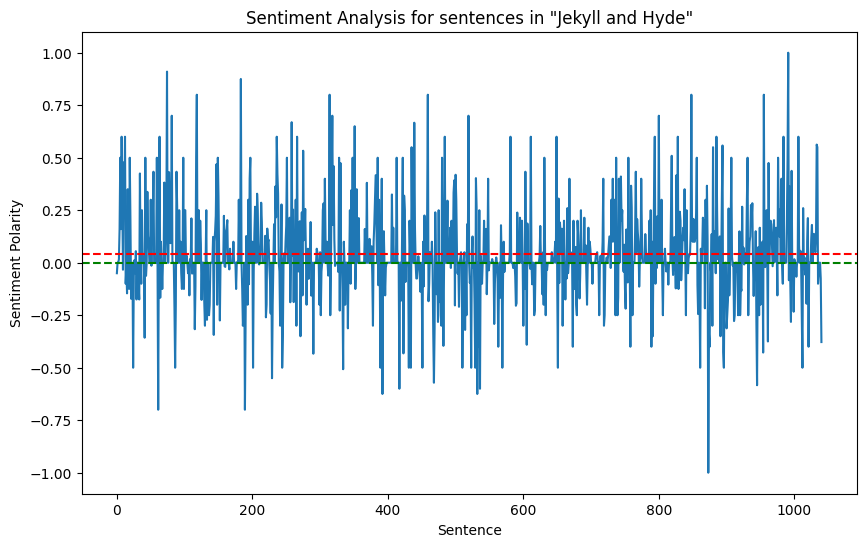

<Figure size 1000x600 with 0 Axes>

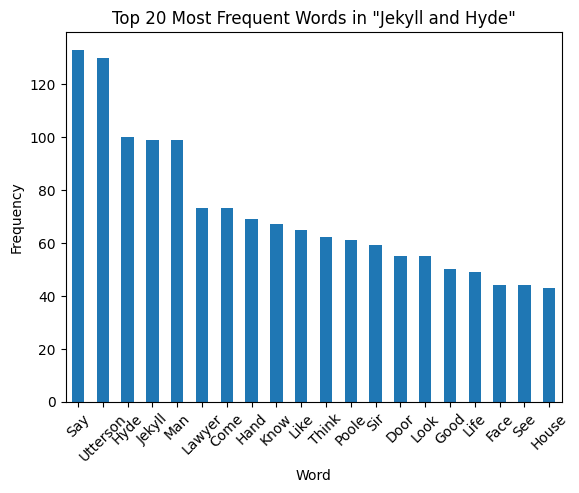

In [137]:
# Show the analysis of the book
jekyll_hyde.get_analysis()

Median Sentiment: 0.09171992663517003


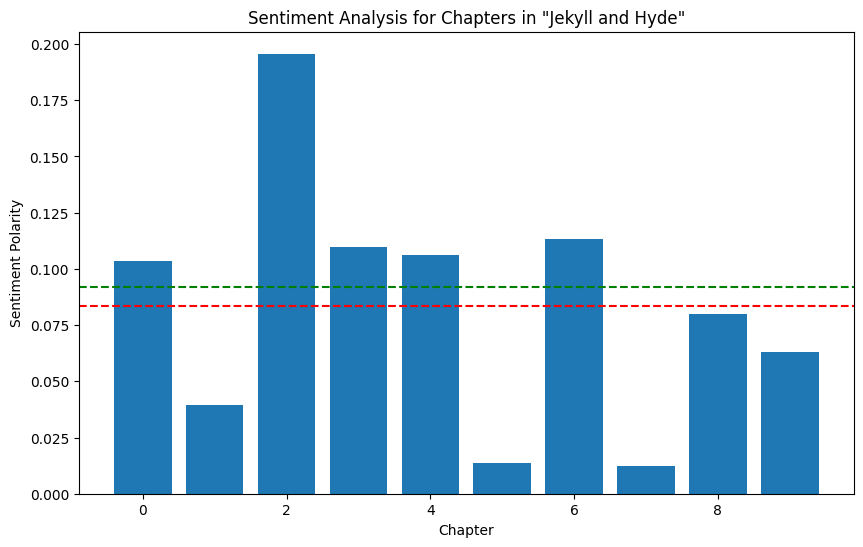

The most positive chapter was Chapter 3: 0.19568254943254937
	Tokens: later
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: excellent
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: good
		Polarity: 0.7
		Subjectivity: 0.6000000000000001

	Tokens: pleasant
		Polarity: 0.7333333333333333
		Subjectivity: 0.9666666666666667

	Tokens: old
		Polarity: 0.1
		Subjectivity: 0.2

	Tokens: intelligent
		Polarity: 0.8
		Subjectivity: 0.9

	Tokens: reputable
		Polarity: 0.5
		Subjectivity: 0.8

	Tokens: good
		Polarity: 0.7
		Subjectivity: 0.6000000000000001

	Tokens: contrived
		Polarity: -0.5
		Subjectivity: 0.75

	Tokens: behind
		Polarity: -0.4
		Subjectivity: 0.7

	Tokens: no, new
		Polarity: -0.06818181818181818
		Subjectivity: 0.45454545454545453

	Tokens: many
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: liked
		Polarity: 0.6
		Subjectivity: 0.8

	Tokens: liked
		Polarity: 0.6
		Subjectivity: 0.8

	Tokens: loved
		Polarity: 0.7
		Subjectivity: 0.8

	Tokens: dry
		Polarity: -0.0666666666666666

In [138]:
# Show the sentiment analysis by chapter
jekyll_hyde.chapter_analysis()


In [139]:
# Add the book to the book object list
books.append(jekyll_hyde)

### Dracula

In [140]:
with open('data\Dracula.txt', 'r', encoding='UTF-8') as file:
    dracula = Book('Dracula', file.read())
chapter_markers = r'(PREFACE.)|(LETTER I+\.)|(CHAPTER [IVXLCDM]+\n)'



In [141]:
dracula.split_into_chapters(chapter_markers)


Number of chapters: 27


In [142]:
dracula.do_nlp(nlp)


In [143]:
dracula.chapter_nlp(nlp)


In [144]:
dracula.blobify()

Blobby Statistics for Dracula
Whole Text Polarity:			0.0753165823494414
Whole Text Subjectivity:		0.5029390985523027



Basic Statistics for Dracula:
	Total Tokens:			204503
	Unique Words:			102195
	Average Sentence Length:	24.875684223330495
	Average Sentence Polarity:	0.05055290442560446
	Average Sentence Subjectivity:	0.35152529301759905

Sentence with highest polarity (1.0):
I was told that this road is in summertime
excellent, but that it had not yet been put in order after the winter
snows.

	Tokens: excellent
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
How was it that all the people at Bistritz and on the
coach had some terrible fear for me?

	Tokens: terrible
		Polarity: -1.0
		Subjectivity: 1.0



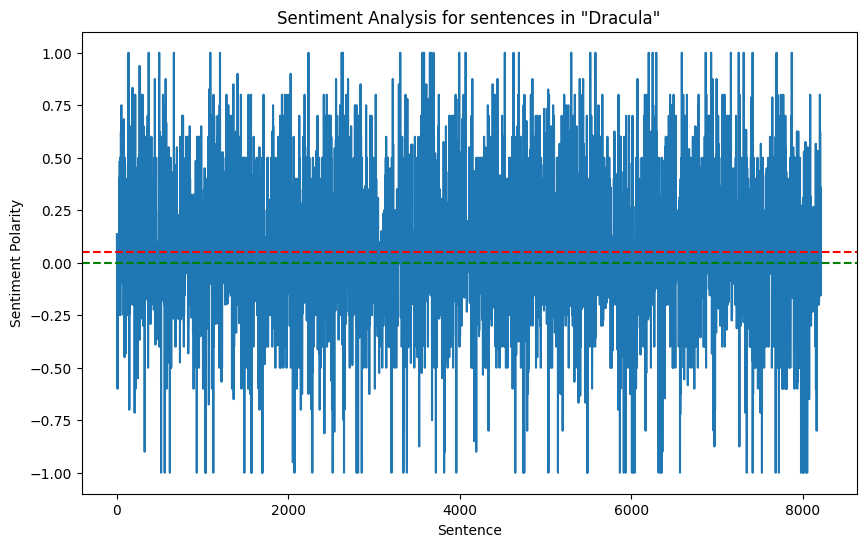

<Figure size 1000x600 with 0 Axes>

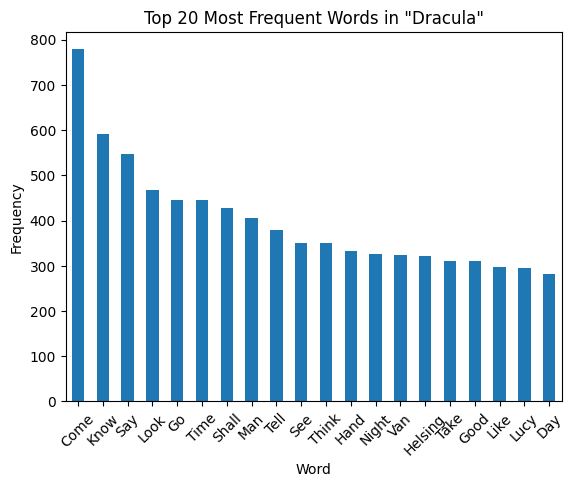

In [145]:
dracula.get_analysis()


Median Sentiment: 0.07448042068178261


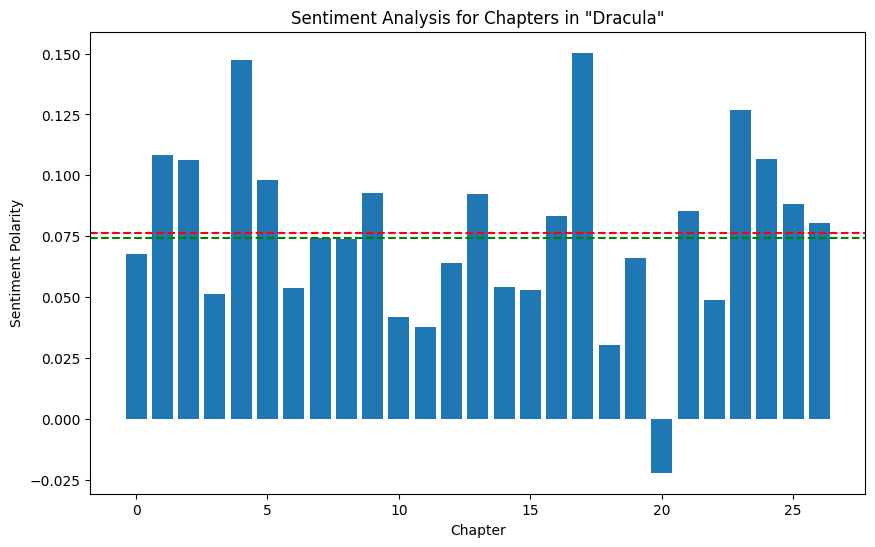

The most positive chapter was Chapter 18: 0.15034064503652142
	Tokens: not, only
		Polarity: -0.0
		Subjectivity: 1.0

	Tokens: various
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: wonderful
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: honestly
		Polarity: 0.6
		Subjectivity: 0.9

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: old
		Polarity: 0.1
		Subjectivity: 0.2

	Tokens: much, !
		Polarity: 0.25
		Subjectivity: 0.2

	Tokens: appealing
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: pretty
		Polarity: 0.25
		Subjectivity: 1.0

	Tokens: no, possible
		Polarity: -0.0
		Subjectivity: 1.0

	Tokens: simply
		Polarity: 0.0
		Subjectivity: 0.35714285714285715

	Tokens: wants
		Polarity: 0.2
		Subjectivity: 0.1

	Tokens: very
		Polarity: 0.2
		Subjectivity: 0.3

	Tokens: tidy
		Polarity: 0.6
		Subjectivity: 0.8

	Tokens: simply
		Polarity: 0.0
		Subjectivity: 0.35714285714285715

	Tokens: evident
		Polarity: 0.25
		Subjectivity: 0.25

	Tokens: disgusting
		Pol

In [146]:
dracula.chapter_analysis()
books.append(dracula)

### Frankenstein

In [147]:
BookImporter.get_book(84, 'Frankenstein')
with open('data\Frankenstein.txt', 'r', encoding='UTF-8') as file:
    frankenstein = Book('Frankenstein', file.read())

chapter_markers = r'\n((Letter .)|(Chapter .+))'
frankenstein.split_into_chapters(chapter_markers)


Number of chapters: 28


In [148]:
frankenstein.do_nlp(nlp)


In [149]:
frankenstein.chapter_nlp(nlp)


In [150]:
frankenstein.blobify()


Blobby Statistics for Frankenstein
Whole Text Polarity:			0.10086658707213995
Whole Text Subjectivity:		0.5395477185484239



Basic Statistics for Frankenstein:
	Total Tokens:			92217
	Unique Words:			47493
	Average Sentence Length:	28.78183520599251
	Average Sentence Polarity:	0.06708833331853943
	Average Sentence Subjectivity:	0.40679099398935653

Sentence with highest polarity (1.0):
Farewell, my dear, excellent Margaret.

	Tokens: excellent
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
But
that would be a cruel kindness, and I dare not do it.

	Tokens: cruel
		Polarity: -1.0
		Subjectivity: 1.0



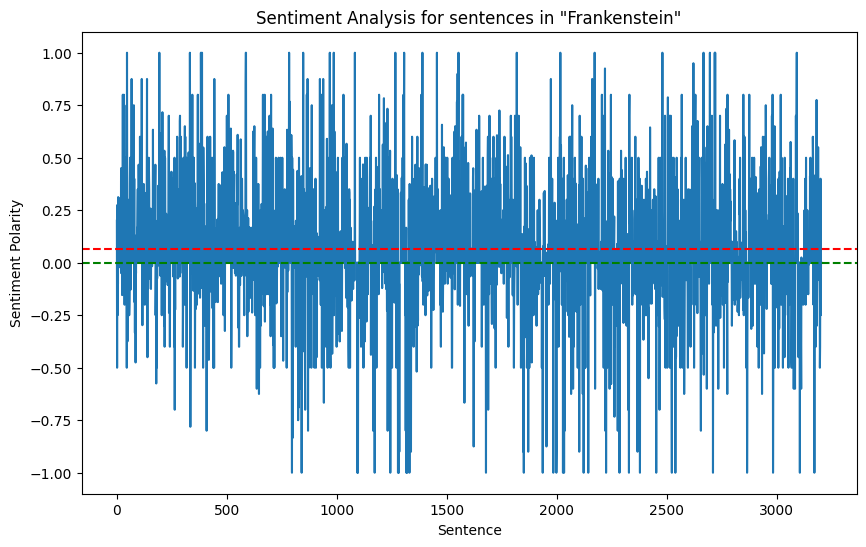

<Figure size 1000x600 with 0 Axes>

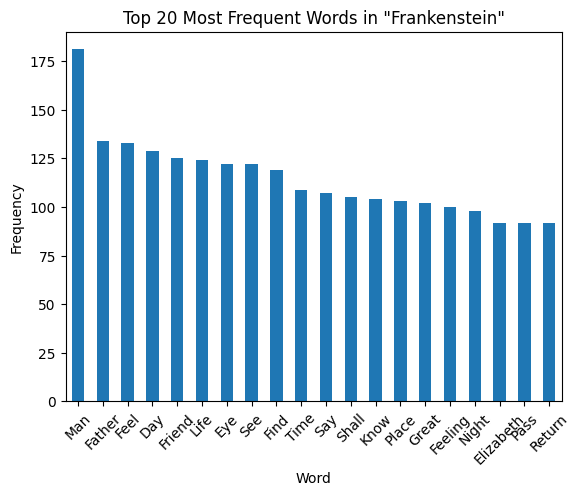

In [151]:
frankenstein.get_analysis()


Median Sentiment: 0.1155247116626006


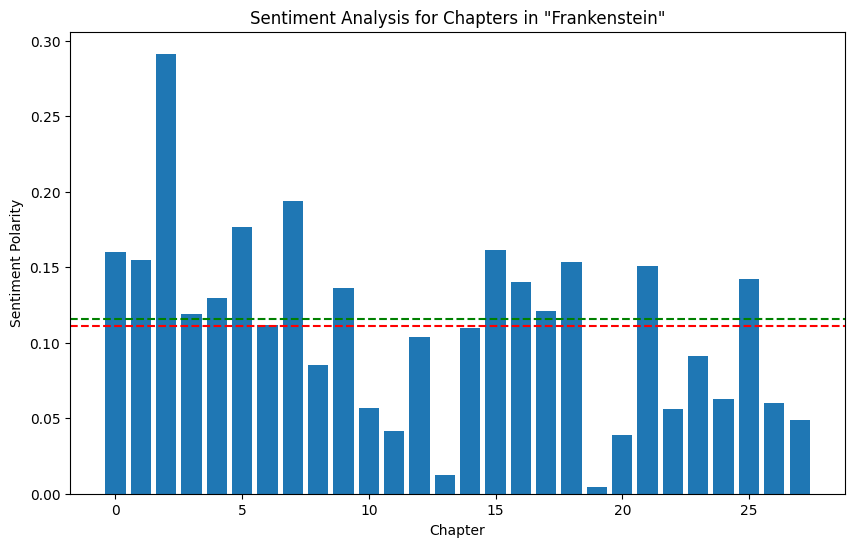

The most positive chapter was Chapter 3: 0.2913933747412008
	Tokens: few
		Polarity: -0.2
		Subjectivity: 0.1

	Tokens: advanced
		Polarity: 0.4
		Subjectivity: 0.6

	Tokens: more
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: fortunate
		Polarity: 0.4
		Subjectivity: 0.7

	Tokens: many
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: good
		Polarity: 0.7
		Subjectivity: 0.6000000000000001

	Tokens: bold
		Polarity: 0.3333333333333333
		Subjectivity: 0.6666666666666666

	Tokens: apparently, firm
		Polarity: -0.2
		Subjectivity: 0.4

	Tokens: very, high
		Polarity: 0.20800000000000002
		Subjectivity: 0.702

	Tokens: warm
		Polarity: 0.6
		Subjectivity: 0.6

	Tokens: southern
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: not, expected
		Polarity: 0.05
		Subjectivity: 0.4

	Tokens: stiff
		Polarity: -0.21428571428571427
		Subjectivity: 0.5

	Tokens: experienced
		Polarity: 0.8
		Subjectivity: 0.9

	Tokens: worse
		Polarity: -0.4
		Subjectivity: 0.6

	Tokens: own
		Polarity: 0.6
		Subjectivity

In [152]:
frankenstein.chapter_analysis()
books.append(frankenstein)

### The Turn of the Screw

In [153]:
BookImporter.get_book(209, 'The Turn of the Screw')
with open('data\The_Turn_of_the_Screw.txt', 'r', encoding='UTF-8') as file:
    turn_of_the_screw = Book('The Turn of the Screw', file.read())

chapter_markers = r'((\nI\n)|(\nII)|(\nIII)|(\nIV)|(\nV)|(\nVI)|(\nVII)|(\nVIII)|(\nIX)|(\nX)|(\nXI)|(\nXII)|(\nXIII)|(\nXIV)|(\nXV)|(\nXVI)|(\nXVII)|(\nXVIII)|(\nXIX)|(\nXX)|(\nXXI)|(\nXXII)|(\nXXIII)|(\nXXIV))'


In [154]:
turn_of_the_screw.split_into_chapters(chapter_markers)


Number of chapters: 24


In [155]:
turn_of_the_screw.do_nlp(nlp)


In [156]:
turn_of_the_screw.chapter_nlp(nlp)


In [157]:
turn_of_the_screw.blobify()


Blobby Statistics for The Turn of the Screw
Whole Text Polarity:			0.08209676744527038
Whole Text Subjectivity:		0.5134243159546995



Basic Statistics for The Turn of the Screw:
	Total Tokens:			56092
	Unique Words:			27524
	Average Sentence Length:	26.941402497598464
	Average Sentence Polarity:	0.05197351025916808
	Average Sentence Subjectivity:	0.36126593514650873

Sentence with highest polarity (1.0):
“For dreadful—dreadfulness!”

“Oh, how delicious!” cried one of the women.



	Tokens: delicious, !
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
It’s quite too
horrible.”

	Tokens: horrible
		Polarity: -1.0
		Subjectivity: 1.0



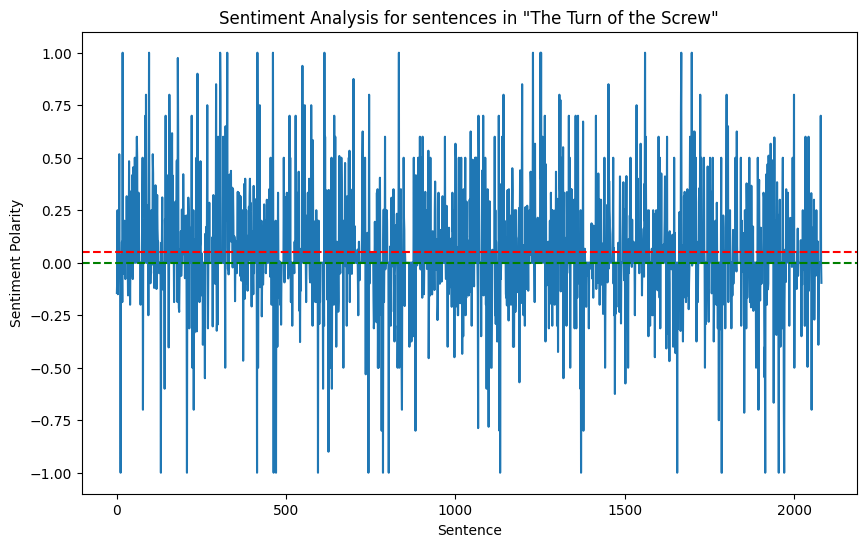

<Figure size 1000x600 with 0 Axes>

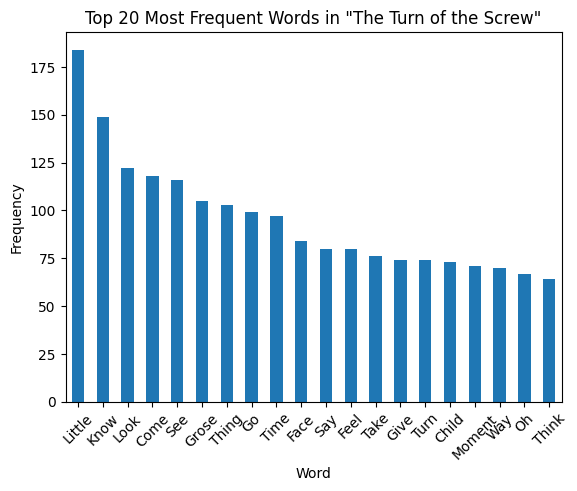

In [158]:
turn_of_the_screw.get_analysis()


Median Sentiment: 0.06916273265484042


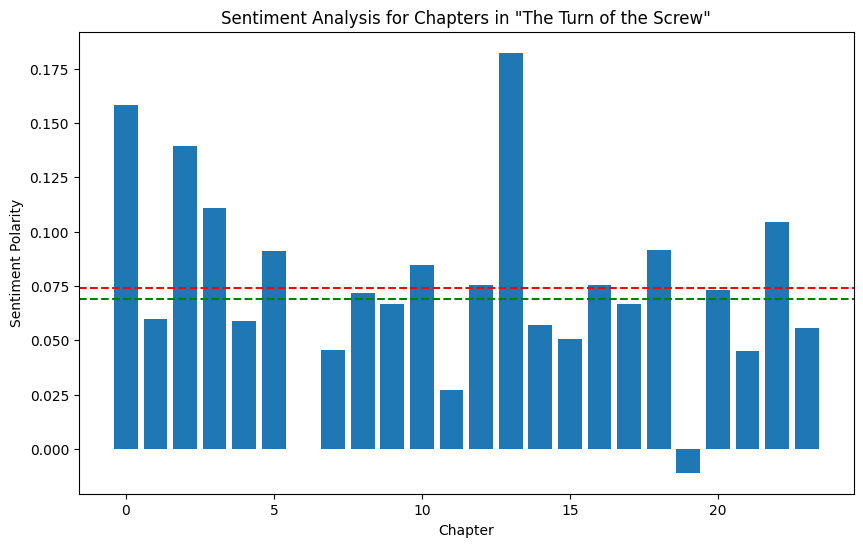

The most positive chapter was Chapter 14: 0.1823420120931183
	Tokens: certain
		Polarity: 0.21428571428571427
		Subjectivity: 0.5714285714285714

	Tokens: little
		Polarity: -0.1875
		Subjectivity: 0.5

	Tokens: crisp
		Polarity: 0.25
		Subjectivity: 0.4166666666666667

	Tokens: clear
		Polarity: 0.10000000000000002
		Subjectivity: 0.3833333333333333

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: bright
		Polarity: 0.7000000000000001
		Subjectivity: 0.7999999999999999

	Tokens: sharp
		Polarity: -0.125
		Subjectivity: 0.75

	Tokens: gay
		Polarity: 0.4166666666666667
		Subjectivity: 0.5833333333333334

	Tokens: odd
		Polarity: -0.16666666666666666
		Subjectivity: 0.25

	Tokens: such
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: particularly
		Polarity: 0.16666666666666666
		Subjectivity: 0.3333333333333333

	Tokens: very
		Polarity: 0.2
		Subjectivity: 0.3

	Tokens: little
		Polarity: -0.1875
		Subjectivity: 0.5

	Tokens: other
		Polarity: -0.125
		Subjec

In [159]:
turn_of_the_screw.chapter_analysis()
books.append(turn_of_the_screw)

### Romeo and Juliet

In [160]:
BookImporter.get_book(1513, 'Romeo and Juliet')
with open('data\Romeo_and_Juliet.txt', 'r', encoding='UTF-8') as file:
    romeo_and_juliet = Book('Romeo and Juliet', file.read())

chapter_markers = r'(THE PROLOGUE\n)|(SCENE I. A public place)|(SCENE II. A Street)|(SCENE III. Room in Capulet’s House)|(SCENE IV. A Street)|(SCENE V. A Hall in Capulet’s House)|(ACT II\n\n)|(SCENE I. An open place adjoining Capulet’s Garden)|(SCENE II. Capulet’s Garden)|(SCENE III. Friar Lawrence’s Cell)|(SCENE IV. A Street)|(SCENE V. Capulet’s Garden)|(SCENE VI. Friar Lawrence’s Cell)|(SCENE I. A public Place)|(SCENE II. A Room in Capulet’s House)|(SCENE III. Friar Lawrence’s cell)|(SCENE IV. A Room in Capulet’s House)|(SCENE V. An open Gallery to Juliet’s Chamber, overlooking the Garden)|(SCENE I. Friar Lawrence’s Cell)|(SCENE II. Hall in Capulet’s House)|(SCENE III. Juliet’s Chamber)|(SCENE IV. Hall in Capulet’s House)|(SCENE V. Juliet’s Chamber; Juliet on the bed)|(SCENE I. Mantua. A Street)|(SCENE II. Friar Lawrence’s Cell)|(SCENE III. A churchyard; in it a Monument belonging to the Capulets)'


In [161]:
romeo_and_juliet.split_into_chapters(chapter_markers)


Number of chapters: 26


In [162]:
romeo_and_juliet.do_nlp(nlp)


In [163]:
romeo_and_juliet.chapter_nlp(nlp)


In [164]:
romeo_and_juliet.blobify()


Blobby Statistics for Romeo and Juliet
Whole Text Polarity:			0.15117404453509595
Whole Text Subjectivity:		0.5303400948667142



Basic Statistics for Romeo and Juliet:
	Total Tokens:			37463
	Unique Words:			23982
	Average Sentence Length:	14.74340810704447
	Average Sentence Polarity:	0.0592589366007663
	Average Sentence Subjectivity:	0.20815429015455014

Sentence with highest polarity (1.0):
Your plantain leaf is excellent for that.

BENVOLIO.


	Tokens: excellent
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
Yea, is the worst well?

	Tokens: worst
		Polarity: -1.0
		Subjectivity: 1.0



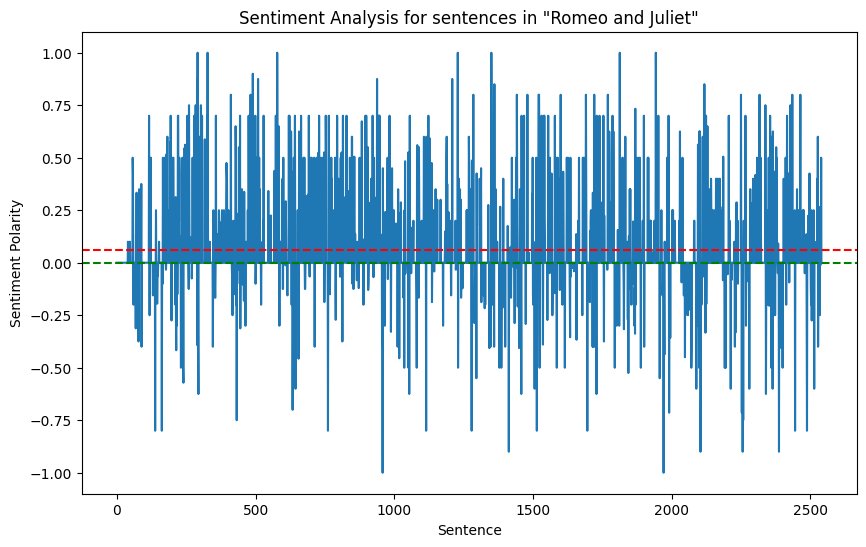

<Figure size 1000x600 with 0 Axes>

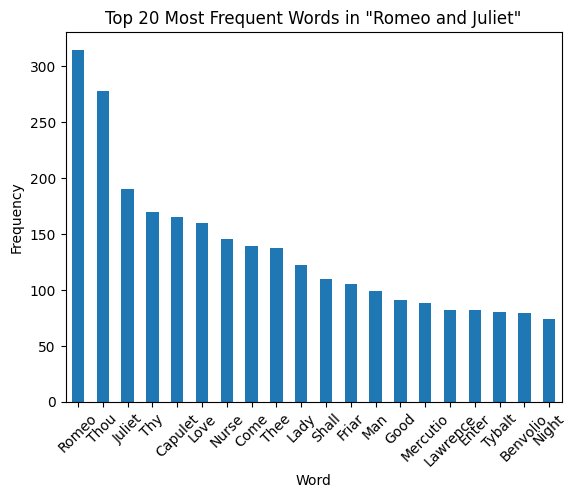

In [165]:
romeo_and_juliet.get_analysis()


Median Sentiment: 0.14671128556092322


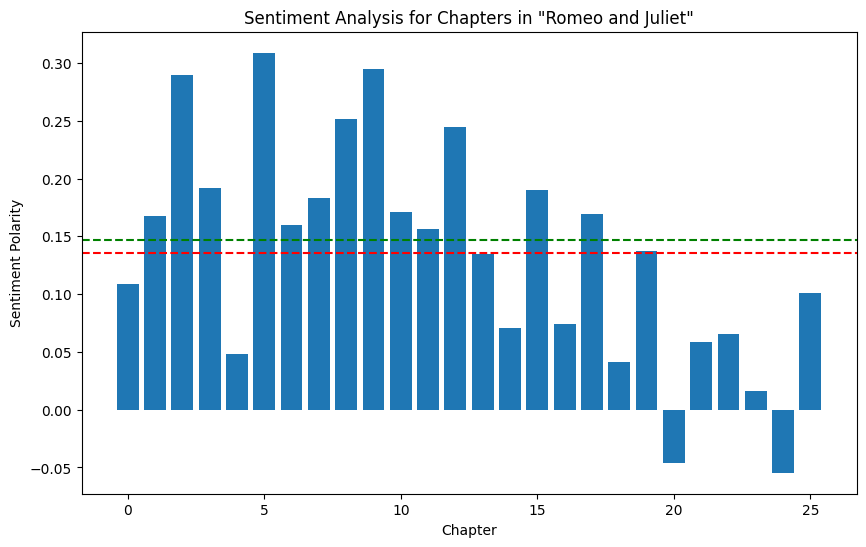

The most positive chapter was Chapter 6: 0.30892668776371296
	Tokens: first, !, !
		Polarity: 0.390625
		Subjectivity: 0.3333333333333333

	Tokens: second
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: good
		Polarity: 0.7
		Subjectivity: 0.6000000000000001

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: good, !
		Polarity: 0.875
		Subjectivity: 0.6000000000000001

	Tokens: second
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: ready
		Polarity: 0.2
		Subjectivity: 0.5

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: second
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: welcome
		Polarity: 0.8
		Subjectivity: 0.9

	Tokens: dainty
		Polarity: 0.9
		Subjectivity: 1.0

	Tokens: near
		Polarity: 0.1
		Subjectivity: 0.4

	Tokens: welcome, !
		Polarity: 1.0
		Subjectivity: 0.9

	Tokens: fair
		Polarity: 0.7
		Subjectivity: 0.9

	Tokens: such
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens

In [166]:
romeo_and_juliet.chapter_analysis()
books.append(romeo_and_juliet)

### Alice's Adventures in Wonderland

In [167]:
BookImporter.get_book(11, 'Alice’s Adventures in Wonderland')
with open('data\Alice’s_Adventures_in_Wonderland.txt', 'r', encoding='UTF-8') as file:
    alice = Book('Alice in Wonderland', file.read())
chapter_markers = r'(CHAPTER I.\nDown the Rabbit-Hole)|(CHAPTER II.\nThe Pool of Tears)|(CHAPTER III.\nA Caucus-Race and a Long Tale)|(CHAPTER IV.\nThe Rabbit Sends in a Little Bill)|(CHAPTER V.\nAdvice from a Caterpillar)|(CHAPTER VI.\nPig and Pepper)|(CHAPTER VII.\nA Mad Tea-Party)|(CHAPTER VIII.\nThe Queen’s Croquet-Ground)|(CHAPTER IX.\nThe Mock Turtle’s Story)|(CHAPTER X.\nThe Lobster Quadrille)|(CHAPTER XI.\nWho Stole the Tarts\?)|(CHAPTER XII.\nAlice’s Evidence)'


In [168]:
alice.split_into_chapters(chapter_markers)


Number of chapters: 12


In [169]:
alice.do_nlp(nlp)


In [170]:
alice.chapter_nlp(nlp)


In [171]:
alice.blobify()


Blobby Statistics for Alice in Wonderland
Whole Text Polarity:			0.04066468707232341
Whole Text Subjectivity:		0.49652185910434093



Basic Statistics for Alice in Wonderland:
	Total Tokens:			37288
	Unique Words:			20321
	Average Sentence Length:	29.593650793650795
	Average Sentence Polarity:	0.027498809276040717
	Average Sentence Subjectivity:	0.3470714248495039

Sentence with highest polarity (1.0):
How brave they’ll all think me
at home!

	Tokens: brave, !
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
And I declare it’s too bad, that it is!”

As she said these words her foot slipped, and in another moment,
splash!

	Tokens: bad, !, !
		Polarity: -1.0
		Subjectivity: 0.6666666666666666



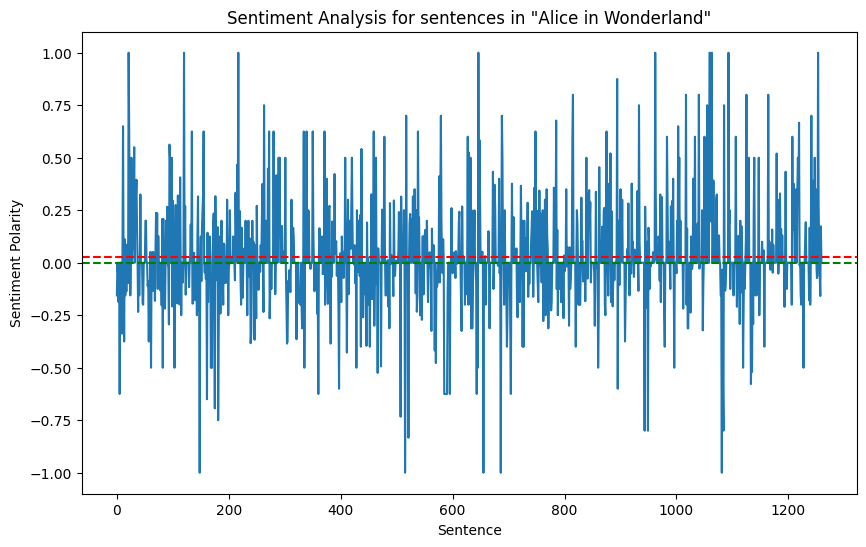

<Figure size 1000x600 with 0 Axes>

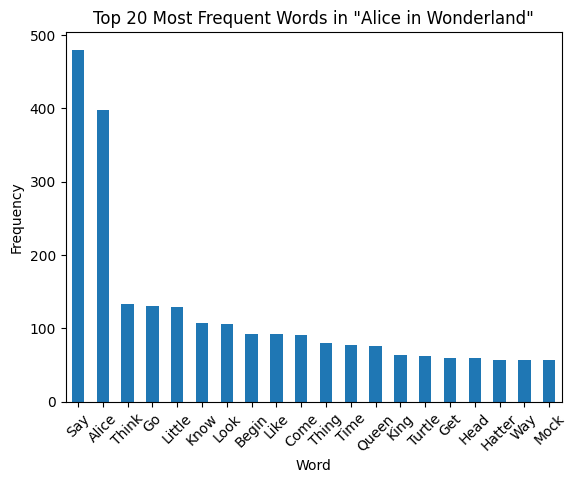

In [172]:
alice.get_analysis()


Median Sentiment: 0.032856661630831556


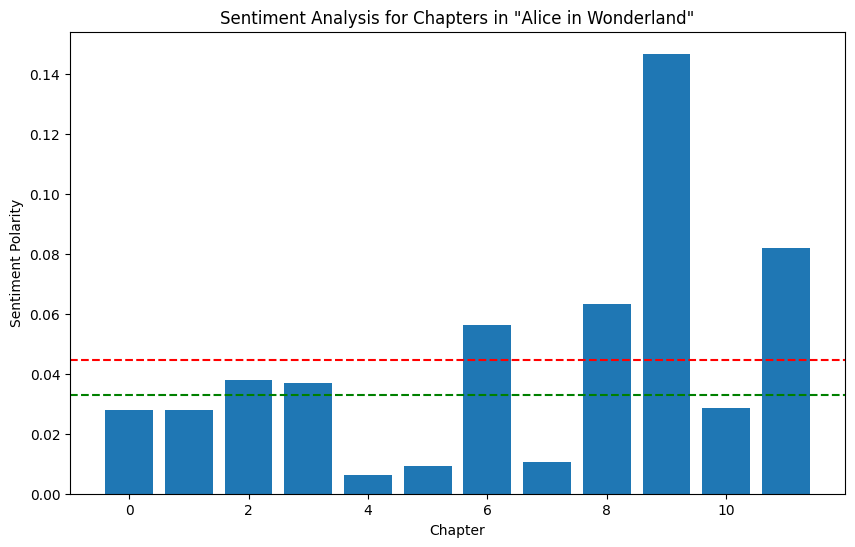

The most positive chapter was Chapter 10: 0.1466299603174603
	Tokens: deeply
		Polarity: 0.0
		Subjectivity: 0.4

	Tokens: back
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: same
		Polarity: 0.0
		Subjectivity: 0.125

	Tokens: back
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: last
		Polarity: 0.0
		Subjectivity: 0.06666666666666667

	Tokens: down
		Polarity: -0.15555555555555559
		Subjectivity: 0.2888888888888889

	Tokens: much
		Polarity: 0.2
		Subjectivity: 0.2

	Tokens: delightful, !
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: first, !
		Polarity: 0.3125
		Subjectivity: 0.3333333333333333

	Tokens: generally, !
		Polarity: 0.06250000000000003
		Subjectivity: 0.5

	Tokens: same, !
		Polarity: 0.0
		Subjectivity: 0.125

	Tokens: far, !, !
		Polarity: 0.15625
		Subjectivity: 1.0

	Tokens: wildly, !
		Polarity: 0.125
		Subjectivity: 0.4

	Tokens: top
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: back
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: first
		Polarity: 0.25
		Subjectivity:

In [173]:
alice.chapter_analysis()
books.append(alice)

### The War of the Worlds

In [174]:
BookImporter.get_book(36, 'War of the Worlds')
with open('data\War_of_the_Worlds.txt', 'r', encoding='UTF-8') as file:
    war_of_the_worlds = Book('War of the Worlds', file.read())

chapter_markers = r'\n[IVX]+\.\n'


In [175]:
war_of_the_worlds.split_into_chapters(chapter_markers)


Number of chapters: 27


In [176]:
war_of_the_worlds.do_nlp(nlp)


In [177]:
war_of_the_worlds.chapter_nlp(nlp)


In [178]:
war_of_the_worlds.blobify()


Blobby Statistics for War of the Worlds
Whole Text Polarity:			0.015814684250657216
Whole Text Subjectivity:		0.46073127062093117



Basic Statistics for War of the Worlds:
	Total Tokens:			75583
	Unique Words:			40697
	Average Sentence Length:	23.738379396984925
	Average Sentence Polarity:	0.011435596127539846
	Average Sentence Subjectivity:	0.3156164445942447

Sentence with highest polarity (1.0):
It seems to me now almost
incredibly wonderful that, with that swift fate hanging over us, men
could go about their petty concerns as they did.

	Tokens: incredibly, wonderful
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
The thought of the confined creature was so dreadful to him that he
forgot the heat and went forward to the cylinder to help turn.

	Tokens: dreadful
		Polarity: -1.0
		Subjectivity: 1.0



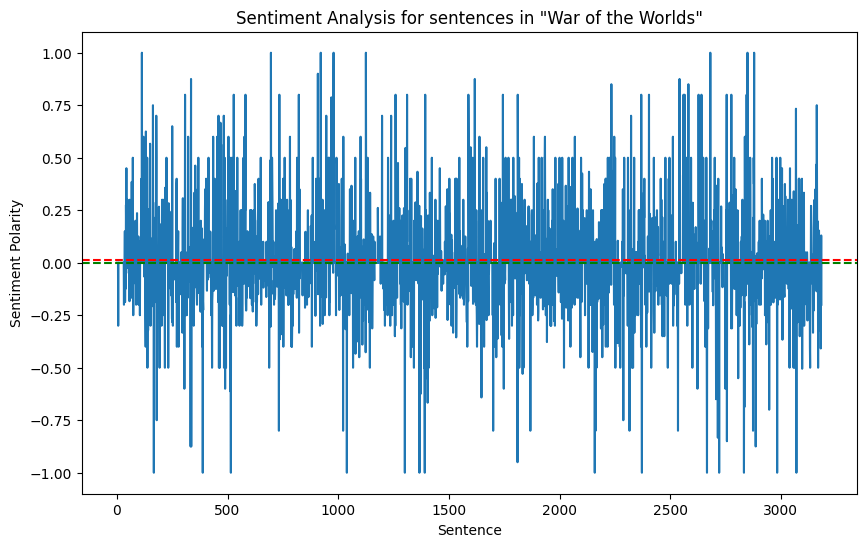

<Figure size 1000x600 with 0 Axes>

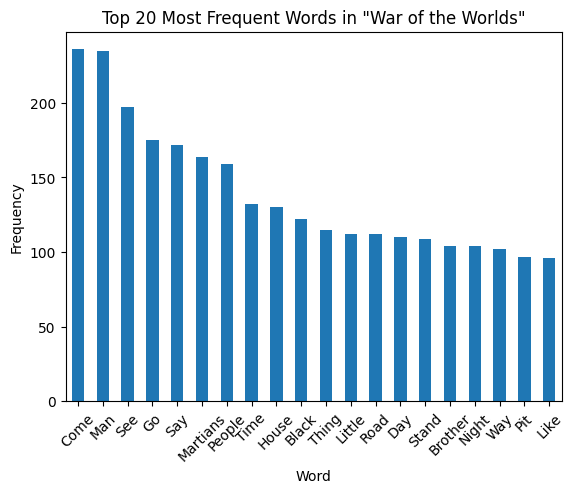

In [179]:
war_of_the_worlds.get_analysis()


Median Sentiment: 0.016110790707830183


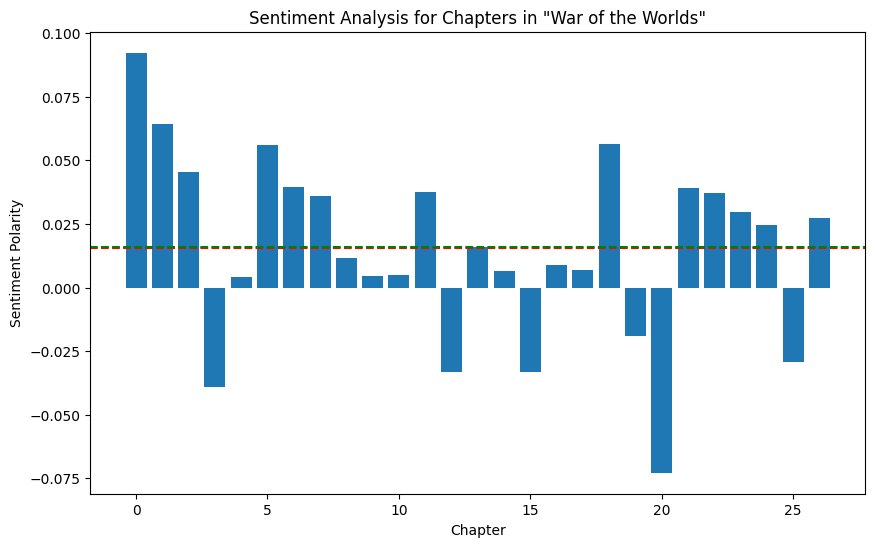

The most positive chapter was Chapter 1: 0.09231482076779107
	Tokens: last
		Polarity: 0.0
		Subjectivity: 0.06666666666666667

	Tokens: greater
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: own
		Polarity: 0.6
		Subjectivity: 1.0

	Tokens: various
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: narrowly
		Polarity: -0.2
		Subjectivity: 0.4

	Tokens: multiply
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: little
		Polarity: -0.1875
		Subjectivity: 0.5

	Tokens: possible
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: same
		Polarity: 0.0
		Subjectivity: 0.125

	Tokens: older
		Polarity: 0.16666666666666666
		Subjectivity: 0.3333333333333333

	Tokens: human
		Polarity: 0.0
		Subjectivity: 0.1

	Tokens: only
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: impossible
		Polarity: -0.6666666666666666
		Subjectivity: 1.0

	Tokens: curious
		Polarity: -0.1
		Subjectivity: 1.0

	Tokens: mental
		Polarity: -0.1
		Subjectivity: 0.2

	Tokens: most
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: terrestria

In [180]:
war_of_the_worlds.chapter_analysis()
books.append(war_of_the_worlds)

### Wuthering Heights

In [181]:
with open('data\Wuthering_Heights.txt', 'r', encoding='UTF-8') as file:
    wuthering_heights = Book('Wuthering Heights', file.read())

chapter_markers = r'CHAPTER [IVX]+'


In [182]:
wuthering_heights.split_into_chapters(chapter_markers)


Number of chapters: 34


In [183]:
wuthering_heights.do_nlp(nlp)


In [184]:
wuthering_heights.chapter_nlp(nlp)


In [185]:
wuthering_heights.blobify()


Blobby Statistics for Wuthering Heights
Whole Text Polarity:			0.04616328478907085
Whole Text Subjectivity:		0.5098336084009212



Basic Statistics for Wuthering Heights:
	Total Tokens:			155358
	Unique Words:			83982
	Average Sentence Length:	26.123759878930553
	Average Sentence Polarity:	0.024480897414461952
	Average Sentence Subjectivity:	0.3277600928638842

Sentence with highest polarity (1.0):
This is certainly a beautiful
country!

	Tokens: certainly, beautiful, !
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
“An awful Sunday,” commenced the paragraph beneath.

	Tokens: awful
		Polarity: -1.0
		Subjectivity: 1.0



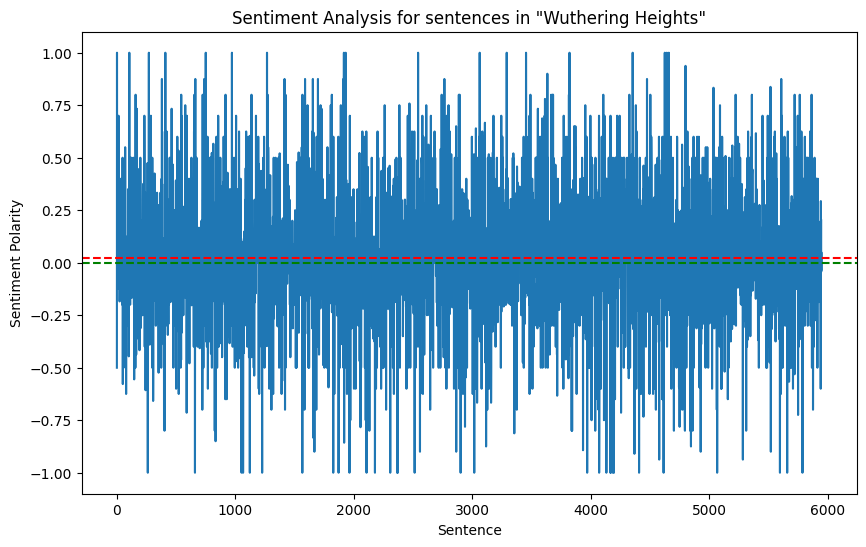

<Figure size 1000x600 with 0 Axes>

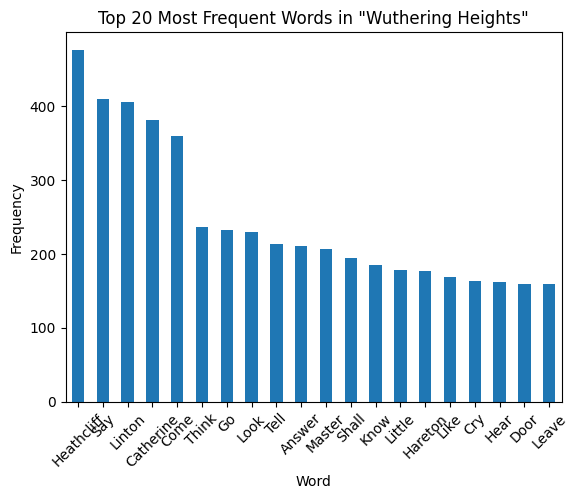

In [186]:
wuthering_heights.get_analysis()


Median Sentiment: 0.053760150375367924


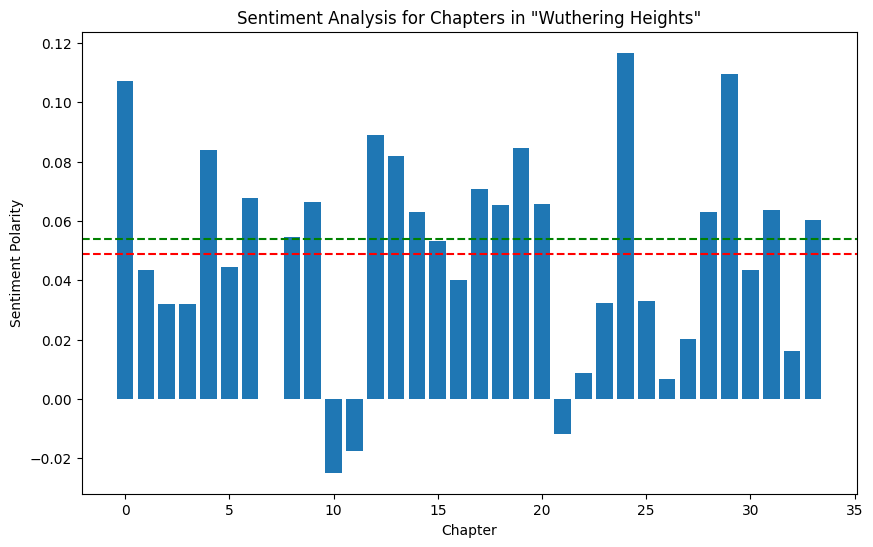

The most positive chapter was Chapter 25: 0.11674058291245788
	Tokens: last
		Polarity: 0.0
		Subjectivity: 0.06666666666666667

	Tokens: hardly, more
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: last
		Polarity: 0.0
		Subjectivity: 0.06666666666666667

	Tokens: amusing, !
		Polarity: 0.75
		Subjectivity: 1.0

	Tokens: long
		Polarity: -0.05
		Subjectivity: 0.4

	Tokens: young
		Polarity: 0.1
		Subjectivity: 0.4

	Tokens: not, love
		Polarity: -0.25
		Subjectivity: 0.6

	Tokens: smile
		Polarity: 0.3
		Subjectivity: 0.1

	Tokens: lively
		Polarity: 0.13636363636363635
		Subjectivity: 0.5

	Tokens: interested
		Polarity: 0.25
		Subjectivity: 0.5

	Tokens: good, !
		Polarity: 0.875
		Subjectivity: 0.6000000000000001

	Tokens: very, possible
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: love
		Polarity: 0.5
		Subjectivity: 0.6

	Tokens: love
		Polarity: 0.5
		Subjectivity: 0.6

	Tokens: much
		Polarity: 0.2
		Subjectivity: 0.2

	Tokens: busy
		Polarity: 0.1
		Subjectivity: 0.3

	Tokens: 

In [187]:
wuthering_heights.chapter_analysis()
books.append(wuthering_heights)

### Pride and Prejudice

In [188]:
with open('data\Pride_and_Prejudice.txt', 'r', encoding='UTF-8') as file:
    pride_prejudice = Book('Pride and Prejudice', file.read())

chapter_markers = r'(Chapter I\.\])|CHAPTER [IVXL]+\.'


In [189]:
pride_prejudice.split_into_chapters(chapter_markers)

Number of chapters: 58


In [190]:
pride_prejudice.do_nlp(nlp)

In [191]:
pride_prejudice.chapter_nlp(nlp)

Basic Statistics for Pride and Prejudice:
	Total Tokens:			163129
	Unique Words:			83191
	Average Sentence Length:	30.164386094674555
	Average Sentence Polarity:	0.09855736315152179
	Average Sentence Subjectivity:	0.4020423273490538

Sentence with highest polarity (1.0):
“What an excellent father you have, girls,” said she, when the door was
shut.

	Tokens: excellent
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
“Oh, shocking!” cried Miss Bingley.

	Tokens: shocking, !
		Polarity: -1.0
		Subjectivity: 1.0



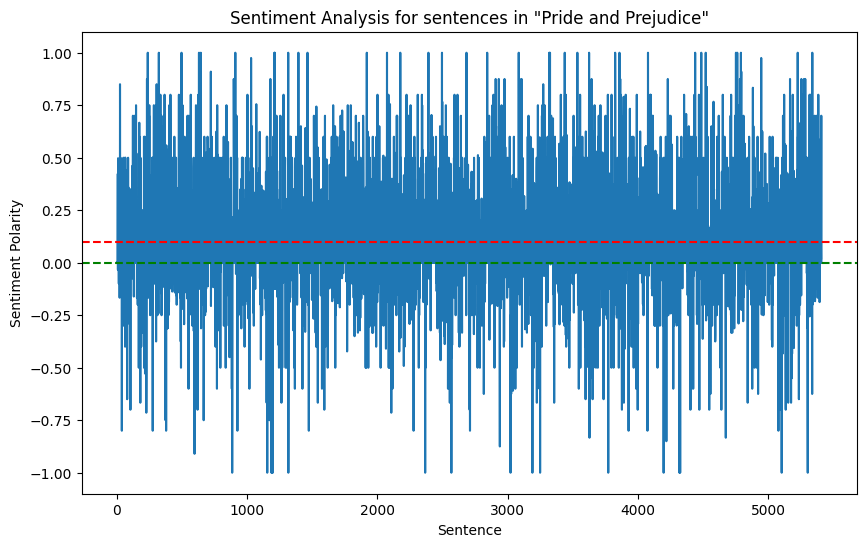

<Figure size 1000x600 with 0 Axes>

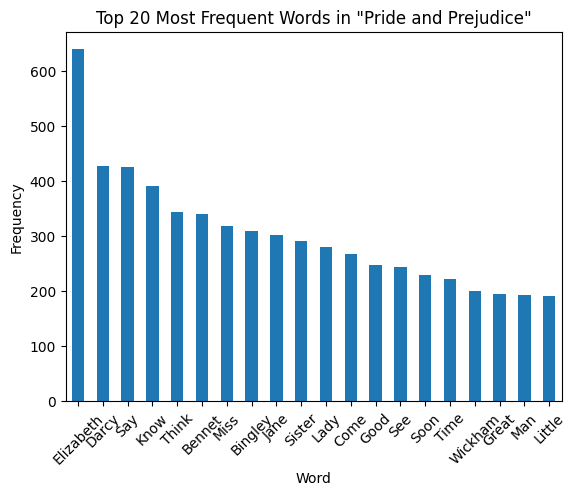

In [192]:
pride_prejudice.get_analysis()


Median Sentiment: 0.13888268770371046


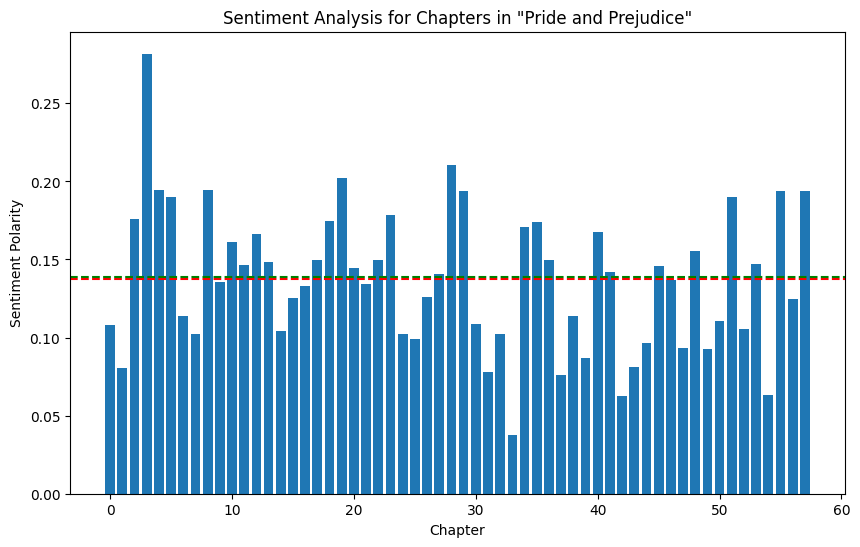

The most positive chapter was Chapter 4: 0.2817675587652224
	Tokens: former
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: very, much
		Polarity: 0.26
		Subjectivity: 0.26

	Tokens: lively
		Polarity: 0.13636363636363635
		Subjectivity: 0.5

	Tokens: such
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: happy, !
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: much
		Polarity: 0.2
		Subjectivity: 0.2

	Tokens: such
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: perfect
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: good, !
		Polarity: 0.875
		Subjectivity: 0.6000000000000001

	Tokens: handsome
		Polarity: 0.5
		Subjectivity: 1.0

	Tokens: young
		Polarity: 0.1
		Subjectivity: 0.4

	Tokens: possibly
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: complete
		Polarity: 0.1
		Subjectivity: 0.4

	Tokens: very, much
		Polarity: 0.26
		Subjectivity: 0.26

	Tokens: second
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: such
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: great
		Polarity: 0.8
		Subjectivity:

In [193]:
pride_prejudice.chapter_analysis()
books.append(pride_prejudice)

### Moby Dick

In [194]:
with open('data\Moby-Dick_or,_the_Whale.txt', 'r', encoding='UTF-8') as file:
    moby_dick = Book('Moby Dick', file.read())


In [195]:
chapter_markers = r'(\nCHAPTER .+)|(\nEPILOGUE.)'

In [196]:

moby_dick.split_into_chapters(chapter_markers)


Number of chapters: 136


In [197]:
moby_dick.do_nlp(nlp, 10000)


c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'blob' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'polarity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'subjectivity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'assessments' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)


In [198]:
moby_dick.chapter_nlp(nlp)


In [199]:
moby_dick.blobify()


Blobby Statistics for Moby Dick
Whole Text Polarity:			0.08274175011449368
Whole Text Subjectivity:		0.47814575662913006



Basic Statistics for Moby Dick:
	Total Tokens:			278474
	Unique Words:			157024
	Average Sentence Length:	30.969083629893237
	Average Sentence Polarity:	0.05535266143153792
	Average Sentence Subjectivity:	0.32898610363932024

Sentence with highest polarity (1.0):
But I lay perfectly still, and resolved not to say a word
till spoken to.

	Tokens: perfectly
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
Yes, it’s just as I thought, he’s a terrible
bedfellow; he’s been in a fight, got dreadfully cut, and here he is,
just from the surgeon.

	Tokens: terrible
		Polarity: -1.0
		Subjectivity: 1.0

	Tokens: dreadfully
		Polarity: -1.0
		Subjectivity: 1.0



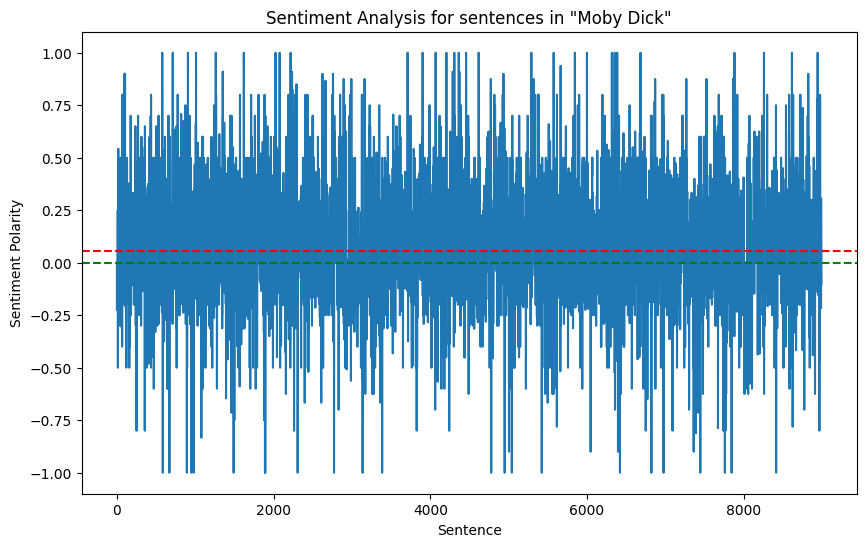

<Figure size 1000x600 with 0 Axes>

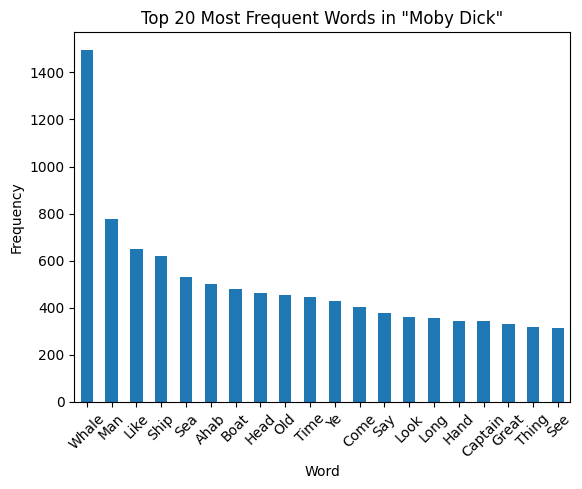

In [200]:
moby_dick.get_analysis()


Median Sentiment: 0.07831483046194432


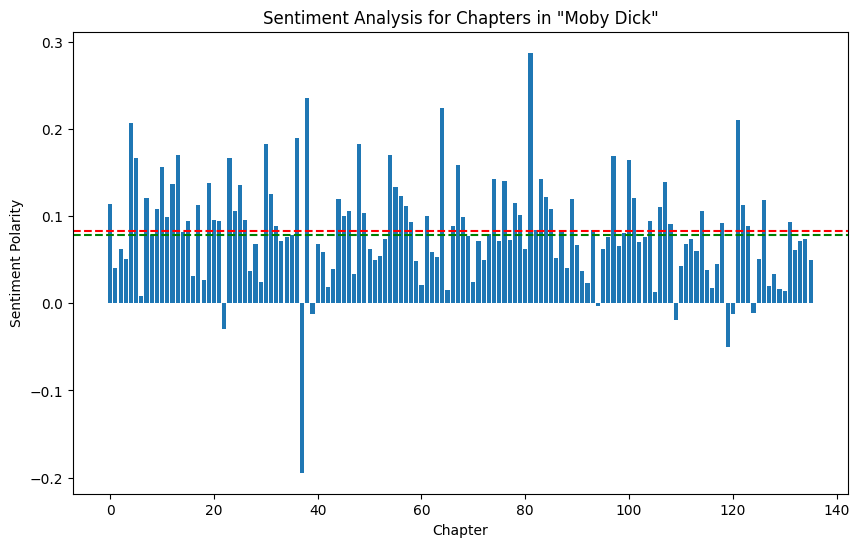

The most positive chapter was Chapter 82: 0.2878038979304802
	Tokens: careful
		Polarity: -0.1
		Subjectivity: 1.0

	Tokens: true
		Polarity: 0.35
		Subjectivity: 0.65

	Tokens: more
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: very
		Polarity: 0.2
		Subjectivity: 0.3

	Tokens: much
		Polarity: 0.2
		Subjectivity: 0.2

	Tokens: more
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: impressed
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: especially
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: many
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: other
		Polarity: -0.125
		Subjectivity: 0.375

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: not, killed
		Polarity: 0.1
		Subjectivity: 0.0

	Tokens: only
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: fine
		Polarity: 0.4166666666666667
		Subjecti

In [201]:
moby_dick.chapter_analysis()
books.append(moby_dick)

### Ulysses

In [202]:
BookImporter.get_book(4300, 'Ulysses')
with open('data\\Ulysses.txt', 'r', encoding='UTF-8') as file:
    ulysses = Book('Ulysses', file.read())


In [203]:
chapter_markers = r''
for i in range(1, 18):
    chapter_markers += r'(\n\[ {} \])|'.format(i)
chapter_markers += r'(\n\[ 18 \])'

In [204]:

ulysses.split_into_chapters(chapter_markers)


Number of chapters: 18


In [205]:
ulysses.do_nlp(nlp, 10000)


c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'blob' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'polarity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'subjectivity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'assessments' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)


In [206]:
ulysses.chapter_nlp(nlp)


In [207]:
ulysses.blobify()


Blobby Statistics for Ulysses
Whole Text Polarity:			0.04590503747026179
Whole Text Subjectivity:		0.4782516778778993



Basic Statistics for Ulysses:
	Total Tokens:			344954
	Unique Words:			208707
	Average Sentence Length:	15.788813621384108
	Average Sentence Polarity:	0.016286736818274233
	Average Sentence Subjectivity:	0.22552822878890397

Sentence with highest polarity (1.0):
O, my name for you
is the best: Kinch, the knife-blade.



	Tokens: best
		Polarity: 1.0
		Subjectivity: 0.3

Sentence with lowest polarity (-1.0):
Come up, you fearful jesuit!



	Tokens: fearful, !
		Polarity: -1.0
		Subjectivity: 1.0



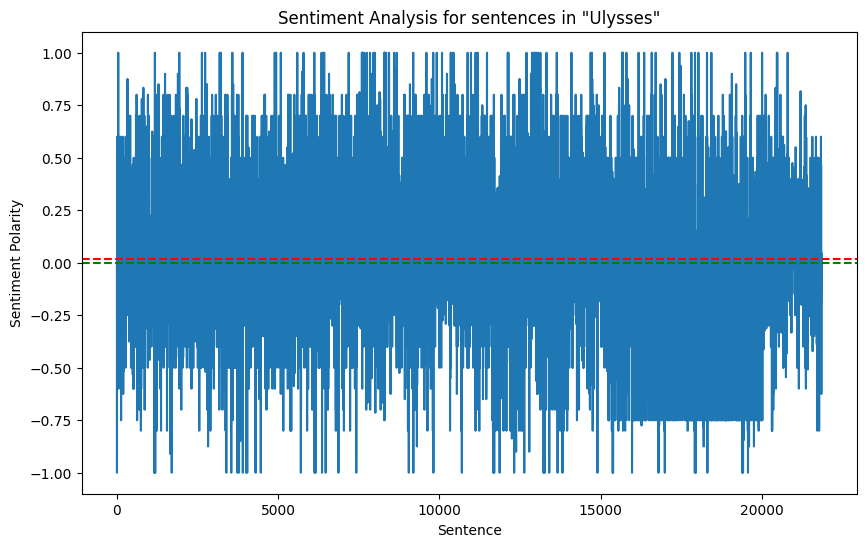

<Figure size 1000x600 with 0 Axes>

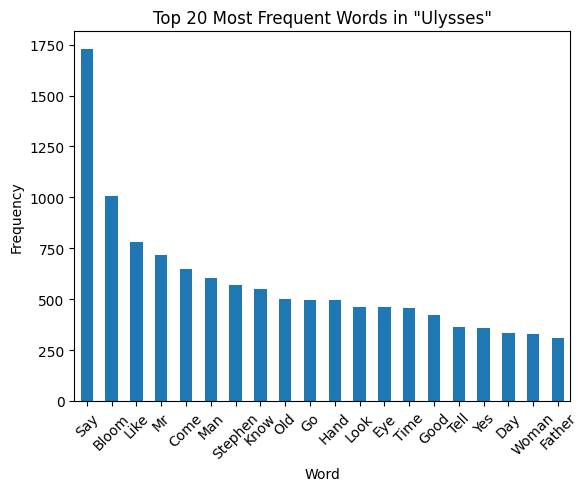

In [208]:

ulysses.get_analysis()


Median Sentiment: 0.05763528418772087


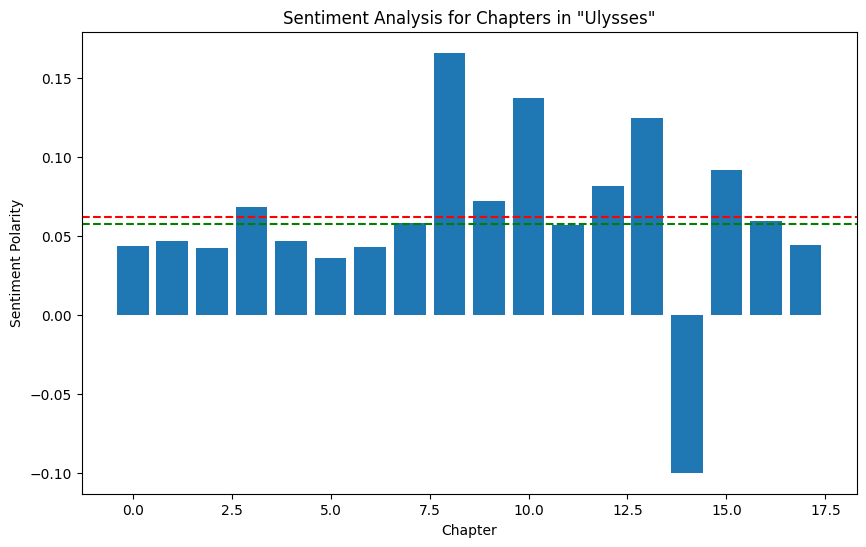

The most positive chapter was Chapter 9: 0.1660534903195309
	Tokens: priceless
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: real
		Polarity: 0.2
		Subjectivity: 0.30000000000000004

	Tokens: attendant
		Polarity: 0.2
		Subjectivity: 0.4

	Tokens: open
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: slightly
		Polarity: -0.16666666666666666
		Subjectivity: 0.16666666666666666

	Tokens: beautiful
		Polarity: 0.85
		Subjectivity: 1.0

	Tokens: grief
		Polarity: -0.8
		Subjectivity: 0.2

	Tokens: hard
		Polarity: -0.2916666666666667
		Subjectivity: 0.5416666666666666

	Tokens: true
		Polarity: 0.35
		Subjectivity: 0.65

	Tokens: true
		Polarity: 0.35
		Subjectivity: 0.65

	Tokens: larger
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: most
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: large
		Polarity: 0.21428571428571427
		Subjectivity: 0.42857142857142855

	Tokens: attendant
		Polarity:

In [209]:
ulysses.chapter_analysis()
books.append(ulysses)

### A Christmas Carol

In [210]:
with open('data\A_Christmas_Carol.txt', 'r', encoding='UTF-8') as file:
    christmas_carol = Book('A Christmas Carol', file.read())

In [211]:
chapter_markers = r'STAVE (.+)'

In [212]:
christmas_carol.split_into_chapters(chapter_markers)

Number of chapters: 5


In [213]:
christmas_carol.do_nlp(nlp)

In [214]:
christmas_carol.chapter_nlp(nlp)

In [215]:
christmas_carol.blobify()

Blobby Statistics for A Christmas Carol
Whole Text Polarity:			0.10297132260911637
Whole Text Subjectivity:		0.4994608844449129



Basic Statistics for A Christmas Carol:
	Total Tokens:			39228
	Unique Words:			21947
	Average Sentence Length:	24.875079264426127
	Average Sentence Polarity:	0.06700052780926624
	Average Sentence Subjectivity:	0.3242960917955689

Sentence with highest polarity (1.0):
But the great effect of the evening came after the Roast
and Boiled, when the fiddler (an artful dog, mind!

	Tokens: great, !
		Polarity: 1.0
		Subjectivity: 0.75

Sentence with lowest polarity (-1.0):
and in the hall appeared the schoolmaster
himself, who glared on Master Scrooge with a ferocious
condescension, and threw him into a dreadful state of mind
by shaking hands with him.

	Tokens: dreadful
		Polarity: -1.0
		Subjectivity: 1.0



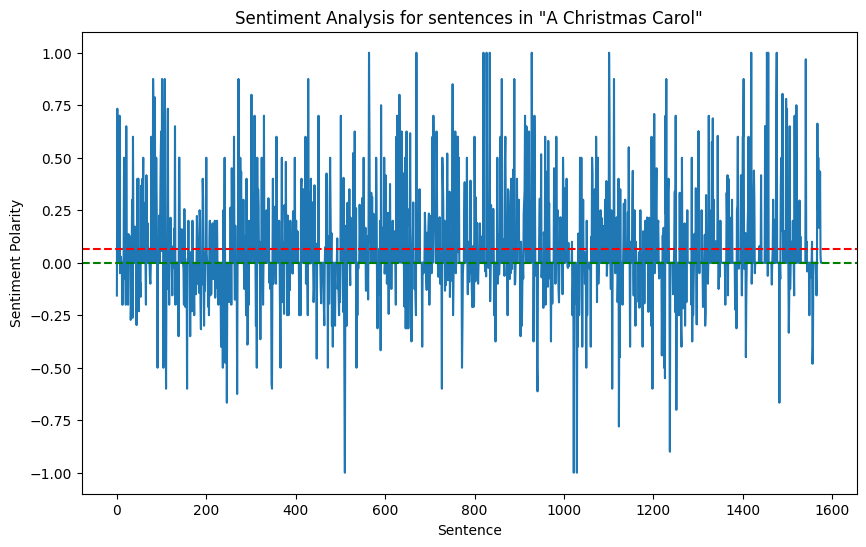

<Figure size 1000x600 with 0 Axes>

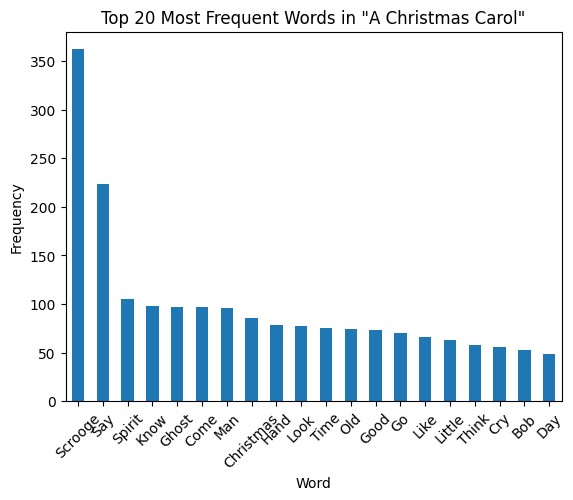

In [216]:
christmas_carol.get_analysis()

Median Sentiment: 0.10417513622901346


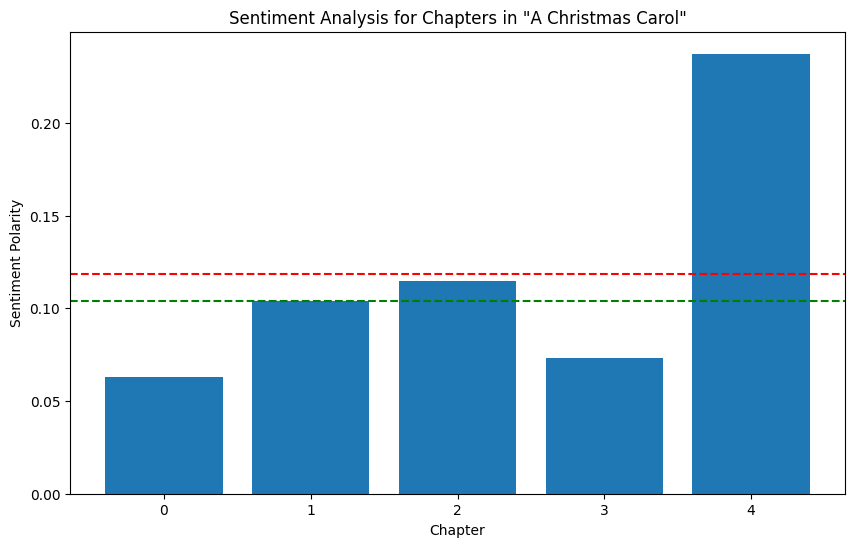

The most positive chapter was Chapter 5: 0.23729997125587265
	Tokens: own
		Polarity: 0.6
		Subjectivity: 1.0

	Tokens: own
		Polarity: 0.6
		Subjectivity: 1.0

	Tokens: own
		Polarity: 0.6
		Subjectivity: 1.0

	Tokens: best
		Polarity: 1.0
		Subjectivity: 0.3

	Tokens: own, !
		Polarity: 0.75
		Subjectivity: 1.0

	Tokens: live
		Polarity: 0.13636363636363635
		Subjectivity: 0.5

	Tokens: past
		Polarity: -0.25
		Subjectivity: 0.25

	Tokens: present
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: future, !, !, !
		Polarity: 0.0
		Subjectivity: 0.125

	Tokens: old, !
		Polarity: 0.125
		Subjectivity: 0.2

	Tokens: good
		Polarity: 0.7
		Subjectivity: 0.6000000000000001

	Tokens: broken
		Polarity: -0.4
		Subjectivity: 0.4

	Tokens: violently
		Polarity: -0.8
		Subjectivity: 1.0

	Tokens: wet
		Polarity: -0.1
		Subjectivity: 0.4

	Tokens: down
		Polarity: -0.15555555555555559
		Subjectivity: 0.2888888888888889

	Tokens: down, !
		Polarity: -0.19444444444444448
		Subjectivity: 0.28888888888

In [217]:
christmas_carol.chapter_analysis()
books.append(christmas_carol)

## Dorian Grey

In [218]:
with open('data\The_Picture_of_Dorian_Gray.txt', 'r', encoding='UTF-8') as file:
    dorian_gray = Book('The Picture of Dorian Gray', file.read())


In [219]:
chapter_markers = r'\n(CHAPTER .+)'

In [220]:
dorian_gray.split_into_chapters(chapter_markers)

Number of chapters: 20


In [221]:
dorian_gray.do_nlp(nlp)

In [222]:
dorian_gray.chapter_nlp(nlp)

In [223]:
dorian_gray.blobify()

Blobby Statistics for The Picture of Dorian Gray
Whole Text Polarity:			0.06991381964989916
Whole Text Subjectivity:		0.5458973341303766



Basic Statistics for The Picture of Dorian Gray:
	Total Tokens:			103393
	Unique Words:			54941
	Average Sentence Length:	17.73464837049743
	Average Sentence Polarity:	0.037681878949243096
	Average Sentence Subjectivity:	0.345837711028256

Sentence with highest polarity (1.0):
“It is your best work, Basil, the best thing you have ever done,” said
Lord Henry languidly.

	Tokens: best
		Polarity: 1.0
		Subjectivity: 0.3

	Tokens: best
		Polarity: 1.0
		Subjectivity: 0.3

Sentence with lowest polarity (-1.0):
I suppose you think me awfully foolish about it?”

“Not at all,” answered Lord Henry, “not at all, my dear Basil.

	Tokens: awfully
		Polarity: -1.0
		Subjectivity: 1.0



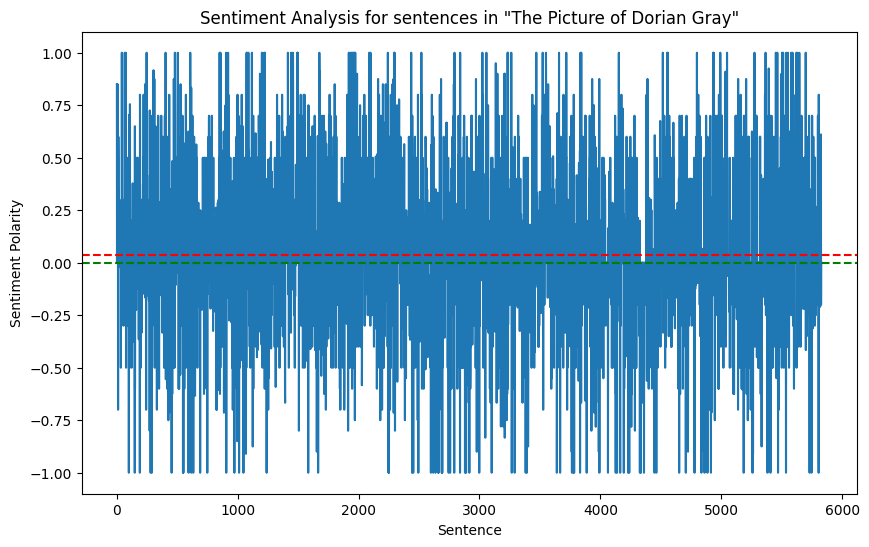

<Figure size 1000x600 with 0 Axes>

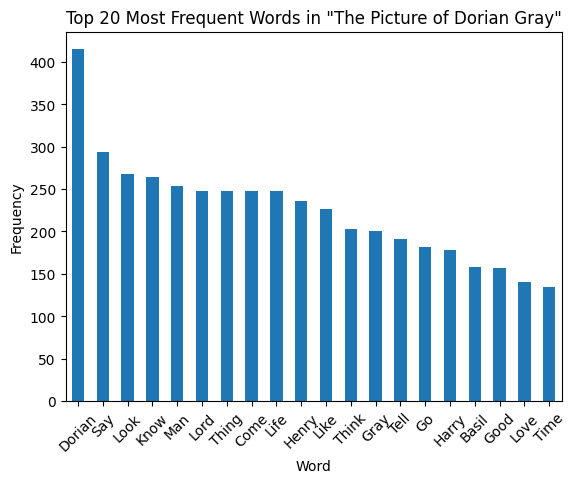

In [224]:
dorian_gray.get_analysis()

Median Sentiment: 0.07460245240485006


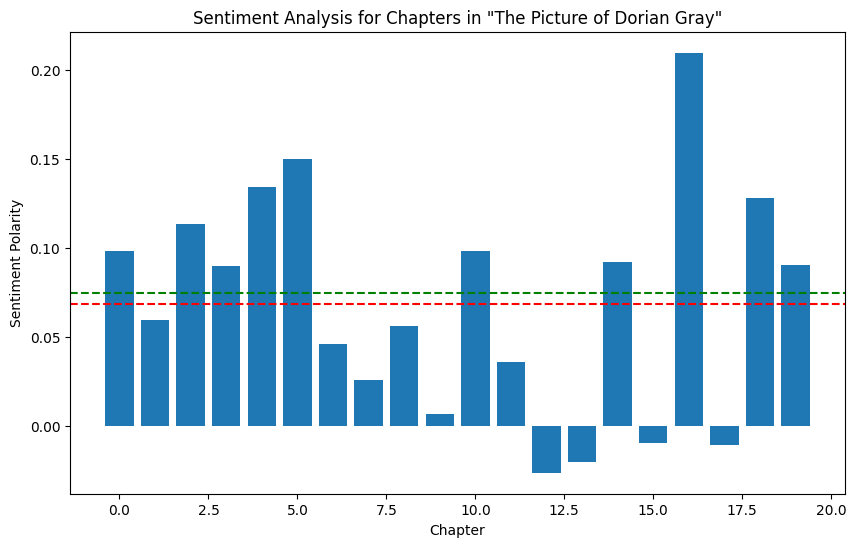

The most positive chapter was Chapter 17: 0.20963250342386375
	Tokens: later
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: pretty
		Polarity: 0.25
		Subjectivity: 1.0

	Tokens: light
		Polarity: 0.4
		Subjectivity: 0.7

	Tokens: huge
		Polarity: 0.4000000000000001
		Subjectivity: 0.9

	Tokens: delicate
		Polarity: -0.3
		Subjectivity: 0.9

	Tokens: white
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: daintily
		Polarity: 0.9
		Subjectivity: 1.0

	Tokens: full
		Polarity: 0.35
		Subjectivity: 0.55

	Tokens: red
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: back
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: last
		Polarity: 0.0
		Subjectivity: 0.06666666666666667

	Tokens: young
		Polarity: 0.1
		Subjectivity: 0.4

	Tokens: elaborate
		Polarity: 0.5
		Subjectivity: 1.0

	Tokens: more
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: expected
		Polarity: -0.1
		Subjectivity: 0.4

	Tokens: next
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: down
		Polarity: -0.15555555555555559
		Subjectivity: 0

In [225]:
dorian_gray.chapter_analysis()
books.append(dorian_gray)

## War and Peace

In [226]:
with open('data\War_and_Peace.txt', 'r', encoding='UTF-8') as file:
    war_and_peace = Book('War and Peace', file.read())


In [227]:
chapter_markers = r'\nCHAPTER [IXVC]+\n'

In [228]:
war_and_peace.split_into_chapters(chapter_markers)

Number of chapters: 365


In [229]:
war_and_peace.do_nlp(nlp)

c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'blob' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'polarity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'subjectivity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'assessments' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)


In [230]:
war_and_peace.chapter_nlp(nlp)

In [231]:
war_and_peace.blobify()

Blobby Statistics for War and Peace
Whole Text Polarity:			0.08250239526102147
Whole Text Subjectivity:		0.47372584916506794



Basic Statistics for War and Peace:
	Total Tokens:			724851
	Unique Words:			392509
	Average Sentence Length:	24.660667505868744
	Average Sentence Polarity:	0.05047073350428187
	Average Sentence Subjectivity:	0.30565683770392355

Sentence with highest polarity (1.0):
“The vicomte is a wonderful raconteur,” said she
to another.

	Tokens: wonderful
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
“Oh, how dreadful!

	Tokens: dreadful, !
		Polarity: -1.0
		Subjectivity: 1.0



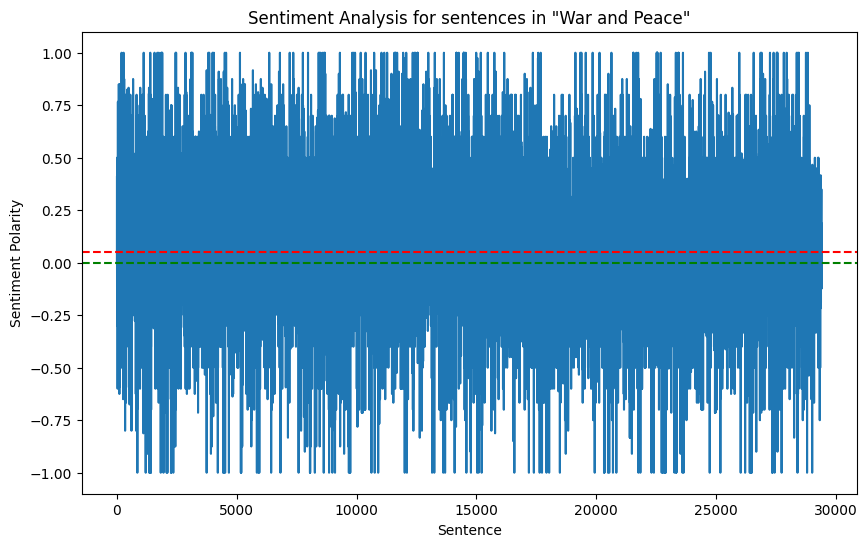

<Figure size 1000x600 with 0 Axes>

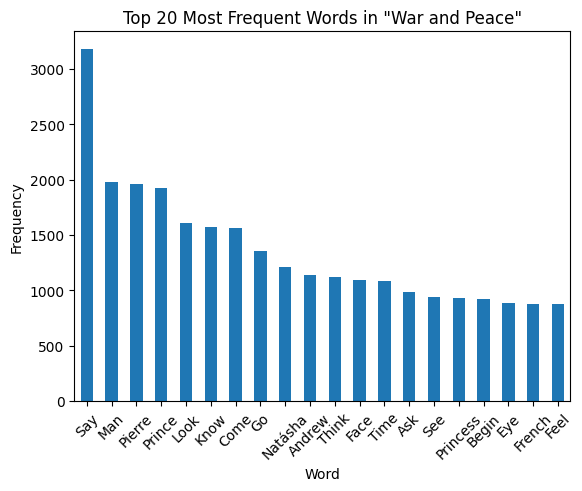

In [232]:
war_and_peace.get_analysis()

Median Sentiment: 0.07514770344959018


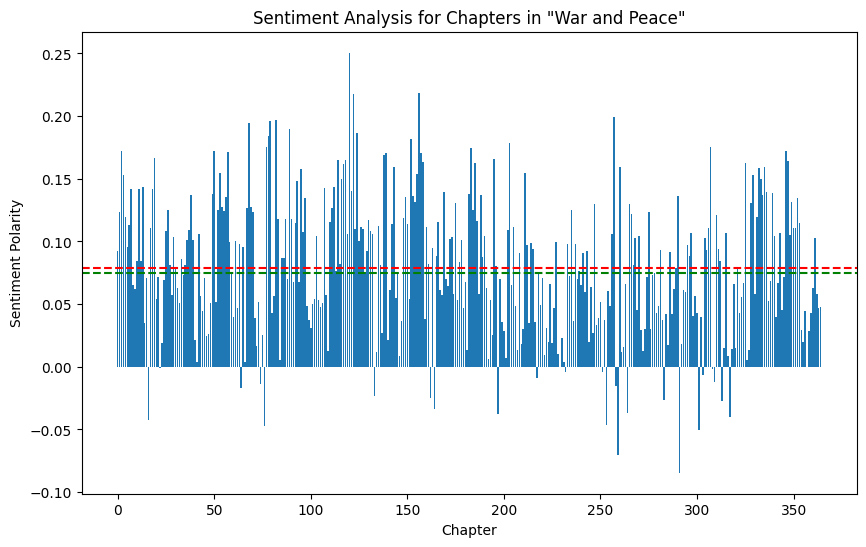

The most positive chapter was Chapter 121: 0.2505470238095238
	Tokens: free
		Polarity: 0.4
		Subjectivity: 0.8

	Tokens: early
		Polarity: 0.1
		Subjectivity: 0.3

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: vividly
		Polarity: 0.125
		Subjectivity: 0.75

	Tokens: brightly
		Polarity: 0.7000000000000001
		Subjectivity: 0.7999999999999999

	Tokens: brilliant
		Polarity: 0.9
		Subjectivity: 1.0

	Tokens: young
		Polarity: 0.1
		Subjectivity: 0.4

	Tokens: splendid
		Polarity: 0.8333333333333334
		Subjectivity: 1.0

	Tokens: hardly
		Polarity: -0.2916666666666667
		Subjectivity: 0.5416666666666666

	Tokens: true
		Polarity: 0.35
		Subjectivity: 0.65

	Tokens: only
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: red
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: brightly
		Polarity: 0.7000000000000001
		Subjectivity: 0.7999999999999999

	Tokens: only
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: indispensable
		Polarity: 0.4
		Subjectivity: 0.9

	Tokens: such

In [233]:
war_and_peace.chapter_analysis()
books.append(war_and_peace)

## The Odyssey

In [234]:
with open('data\The_Odyssey.txt', 'r', encoding='UTF-8') as file:
    
    # Remove the footnotes
    book_text = file.read().split('FOOTNOTES')[1]
    odyssey = Book('The Odyssey', book_text)

chapter_markers = r'\nBOOK .+'

In [235]:
odyssey.split_into_chapters(chapter_markers)

Number of chapters: 24


In [236]:
odyssey.do_nlp(nlp)

In [237]:
odyssey.chapter_nlp(nlp)

In [238]:
odyssey.blobify()

Blobby Statistics for The Odyssey
Whole Text Polarity:			0.1374636785043943
Whole Text Subjectivity:		0.5052790234122657



Basic Statistics for The Odyssey:
	Total Tokens:			147646
	Unique Words:			71261
	Average Sentence Length:	40.8765227021041
	Average Sentence Polarity:	0.10938210245574648
	Average Sentence Subjectivity:	0.400126270464204

Sentence with highest polarity (1.0):
You are indeed wonderfully like him about the head
and eyes, for we were close friends before he set sail for Troy where
the flower of all the Argives went also.

	Tokens: wonderfully
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
Is this the worst fate you can think of
for me?

	Tokens: worst
		Polarity: -1.0
		Subjectivity: 1.0



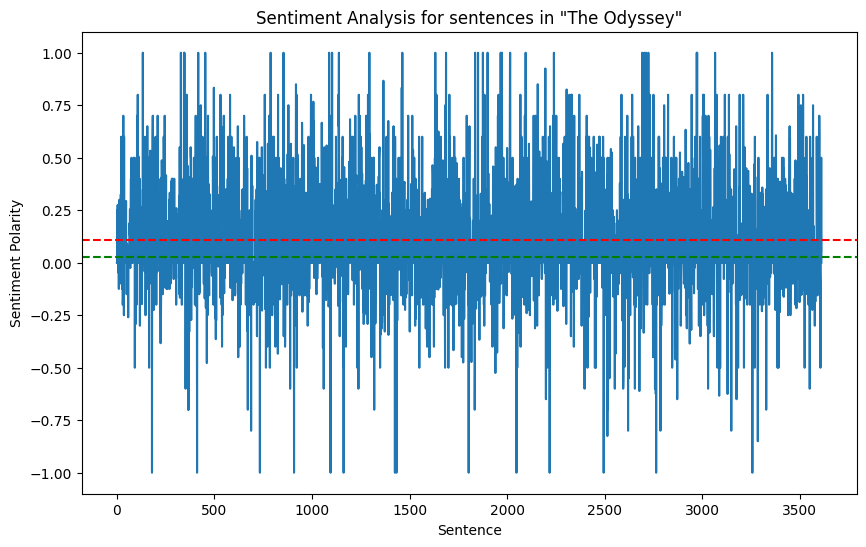

<Figure size 1000x600 with 0 Axes>

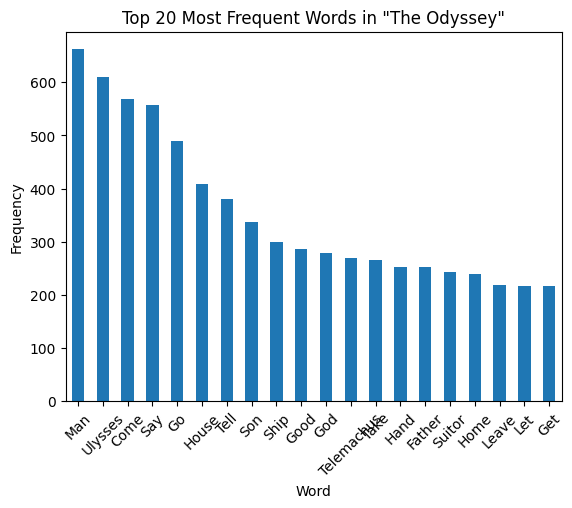

In [239]:
odyssey.get_analysis()

Median Sentiment: 0.1346828977147646


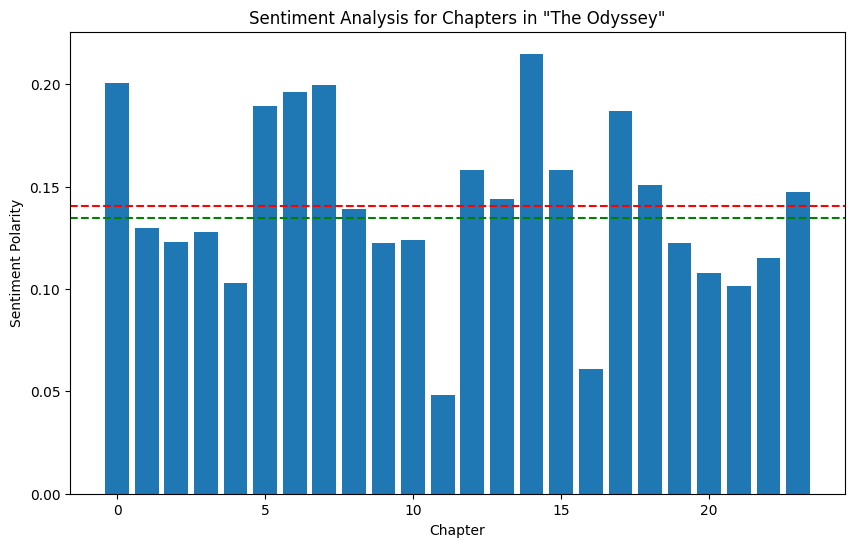

The most positive chapter was Chapter 15: 0.21496688584783838
	Tokens: fair
		Polarity: 0.7
		Subjectivity: 0.9

	Tokens: fast
		Polarity: 0.2
		Subjectivity: 0.6

	Tokens: unhappy
		Polarity: -0.6
		Subjectivity: 0.9

	Tokens: far
		Polarity: 0.1
		Subjectivity: 1.0

	Tokens: such
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: dangerous
		Polarity: -0.6
		Subjectivity: 0.9

	Tokens: excellent
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: back
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: more
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: greatly
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: best
		Polarity: 1.0
		Subjectivity: 0.3

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: dead
		Polarity: -0.2
		Subjectivity: 0.4

	Tokens: most
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: respectable
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: own
		Polarity: 0.6
		Subjectivity: 1.0

	Tokens: better
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: mean
		Polarity: -

In [240]:
odyssey.chapter_analysis()
books.append(odyssey)

## Conduct similarity analysis and display results

In [241]:
# Do a similarity analysis between each book in the books list
checker = SimilarityChecker(books)
checker.calculate_all_similarities()


c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\similarity.py:12: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  first_sentence.similarity(second_sentence)


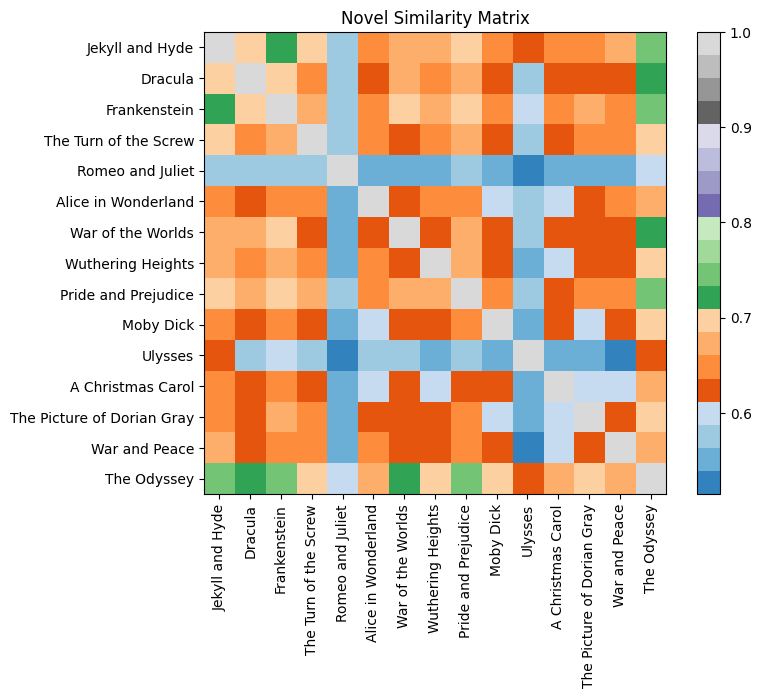

In [272]:
# Show the results of the similarity analysis
checker.display_matrix()

## Let's do some more

In [273]:
'''
The Top 10 Books in the Database

The Lord of the Rings: j.r.r. tolkien, 4.52, data/The_Lord_of_the_Rings.txt
The Adventures of Sherlock Holmes (Sherlock Holmes, #3): arthur conan doyle, 4.3, data/The_Adventures_of_Sherlock_Holmes_(Sherlock_Holmes,_#3).txt
The Count of Monte Cristo: alexandre dumas, 4.29, data/The_Count_of_Monte_Cristo.txt
Pride and Prejudice: jane austen, 4.28, data/Pride_and_Prejudice.txt
It: stephen king, 4.25, data/It.txt
Tomorrow, and Tomorrow, and Tomorrow: gabrielle zevin, 4.24, data/Tomorrow,_and_Tomorrow,_and_Tomorrow.txt
The Hitchhiker's Guide to the Galaxy (The Hitchhiker's Guide to the Galaxy, #1): douglas adams, 4.23, data/The_Hitchhiker's_Guide_to_the_Galaxy_(The_Hitchhiker's_Guide_to_the_Galaxy,_#1).txt
Les Misérables: victor hugo, 4.2, data/Les_Misérables.txt
The Secret Garden: frances hodgson burnett, 4.15, data/The_Secret_Garden.txt
War and Peace: leo tolstoy, 4.15, data/War_and_Peace.txt
'''

more_books = []

### Sherlock Holmes

In [274]:
with open('data\The_Adventures_of_Sherlock_Holmes_(Sherlock_Holmes,_#3).txt', 'r', encoding='UTF-8') as file:
    
    # Remove the footnotes
    book_text = file.read().split(r'XII.   The Adventure of the Copper Beeches')[1]
    sherlock = Book('Sherlock Holmes', book_text)

chapter_markers = r'I. A SCANDAL IN BOHEMIA|II. The Red-Headed League|III. A Case of Identity|IV. The Boscombe Valley Mystery|V. The Five Orange Pips|VI. The Man with the Twisted Lip|VII. The Adventure of the Blue Carbuncle|VIII. The Adventure of the Speckled Band|IX. The Adventure of the Engineer’s Thumb|X. The Adventure of the Noble Bachelor|XI. The Adventure of the Beryl Coronet|XII. The Adventure of the Copper Beeches'.upper()

In [275]:
sherlock.split_into_chapters(chapter_markers)

Number of chapters: 12


In [276]:
sherlock.do_nlp(nlp)

In [277]:
sherlock.chapter_nlp(nlp)

In [278]:
sherlock.blobify()

Blobby Statistics for Sherlock Holmes
Whole Text Polarity:			0.06290159124289049
Whole Text Subjectivity:		0.4867470942171474



Basic Statistics for Sherlock Holmes:
	Total Tokens:			136742
	Unique Words:			70742
	Average Sentence Length:	24.781080101486047
	Average Sentence Polarity:	0.042981963767351195
	Average Sentence Subjectivity:	0.3364549631496021

Sentence with highest polarity (1.0):
There is a wonderful sympathy and
freemasonry among horsey men.

	Tokens: wonderful
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
That is very bad!

	Tokens: very, bad, !
		Polarity: -1.0
		Subjectivity: 0.8666666666666667



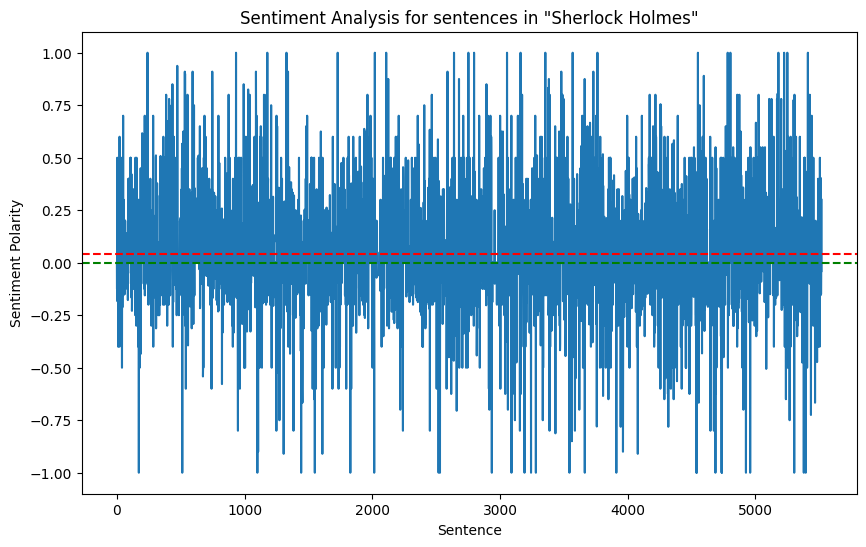

<Figure size 1000x600 with 0 Axes>

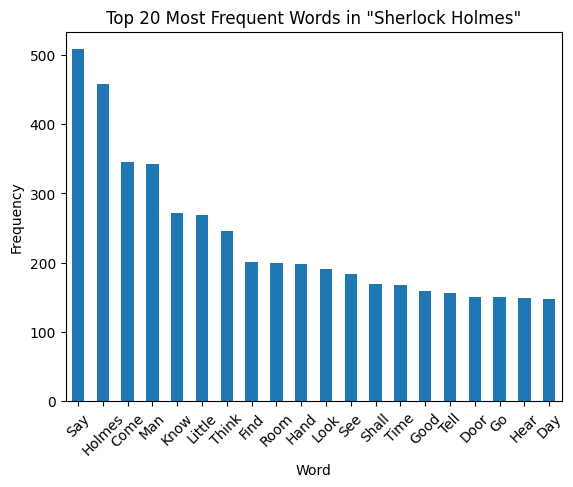

In [279]:
sherlock.get_analysis()

Median Sentiment: 0.055073045491886116


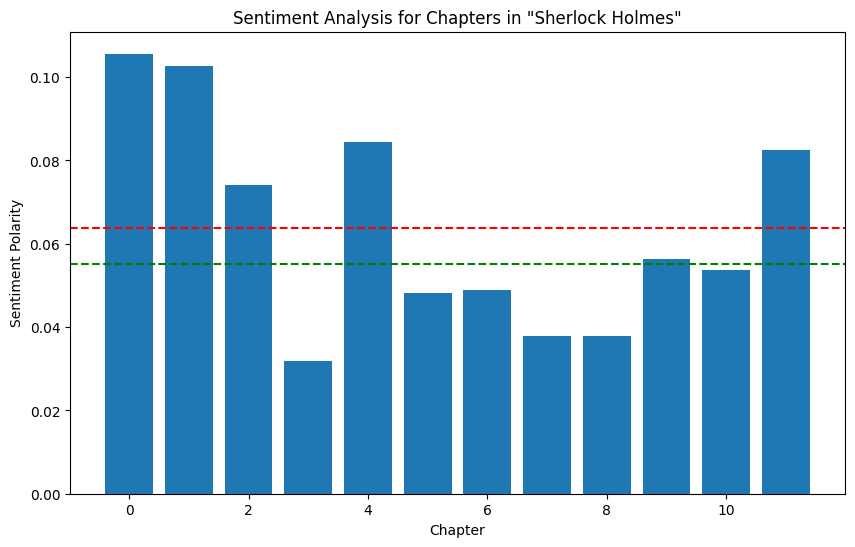

The most positive chapter was Chapter 1: 0.10562456606240991
	Tokens: other
		Polarity: -0.125
		Subjectivity: 0.375

	Tokens: whole
		Polarity: 0.2
		Subjectivity: 0.4

	Tokens: love
		Polarity: 0.5
		Subjectivity: 0.6

	Tokens: particularly
		Polarity: 0.16666666666666666
		Subjectivity: 0.3333333333333333

	Tokens: abhorrent
		Polarity: -0.7
		Subjectivity: 0.8

	Tokens: cold
		Polarity: -0.6
		Subjectivity: 1.0

	Tokens: precise
		Polarity: 0.4
		Subjectivity: 0.8

	Tokens: most
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: perfect
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: false
		Polarity: -0.4000000000000001
		Subjectivity: 0.6

	Tokens: such
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: own
		Polarity: 0.6
		Subjectivity: 1.0

	Tokens: delicate
		Polarity: -0.3
		Subjectivity: 0.9

	Tokens: finely
		Polarity: 0.4166666666666667
		Subjectivity: 0.5

	Tokens: mental
		Polarity: -0.1
		Subjectivity: 0.2

	Tokens: sensitive
		Polarity: 0.1
		Subjectivity: 0.9

	Tokens: own
		Pol

In [280]:
sherlock.chapter_analysis()
books.append(sherlock)

### The Count of Monte Cristo

In [281]:
with open('data\The_Count_of_Monte_Cristo.txt', 'r', encoding='UTF-8') as file:
    
    # Remove the footnotes
    book_text = file.read().split(r' VOLUME ONE')[1]
    cristo = Book('The Count of Monte Cristo', book_text)

chapter_markers = r'Chapter .+'


In [282]:
cristo.split_into_chapters(chapter_markers)

Number of chapters: 117


In [283]:
cristo.do_nlp(nlp)

c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'blob' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'polarity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'subjectivity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'assessments' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)


In [284]:
cristo.chapter_nlp(nlp)

In [285]:
cristo.blobify()

Blobby Statistics for The Count of Monte Cristo
Whole Text Polarity:			0.09311359588530878
Whole Text Subjectivity:		0.4974683928743835



Basic Statistics for The Count of Monte Cristo:
	Total Tokens:			626284
	Unique Words:			355179
	Average Sentence Length:	33.40894057398912
	Average Sentence Polarity:	0.0603569270398863
	Average Sentence Subjectivity:	0.3391465779676361

Sentence with highest polarity (1.0):
“No, no, my dear Edmond—my boy—my son!—no; but I did not expect you;
and joy, the surprise of seeing you so suddenly—Ah, I feel as if I were
going to die.”

“Come, come, cheer up, my dear father! ’

	Tokens: joy, !
		Polarity: 1.0
		Subjectivity: 0.2

Sentence with lowest polarity (-1.0):
No, Fernand, you will not thus give way to evil
thoughts.

	Tokens: evil
		Polarity: -1.0
		Subjectivity: 1.0



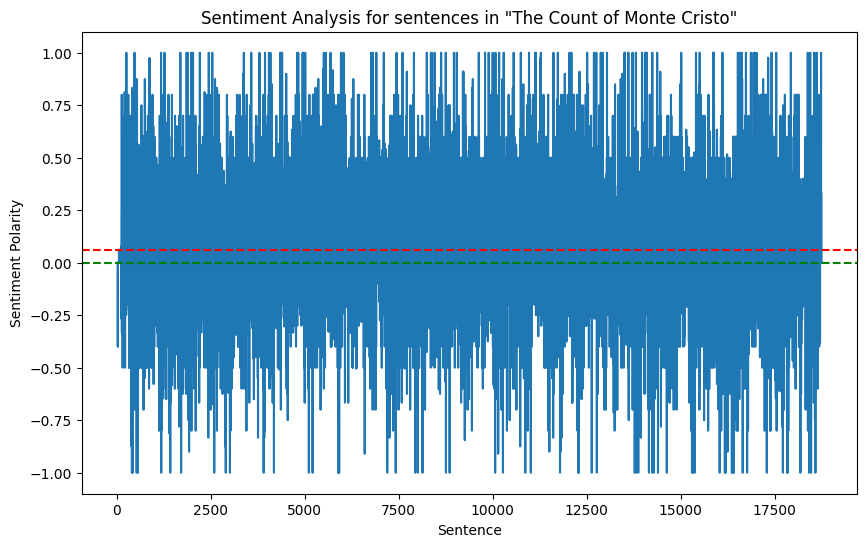

<Figure size 1000x600 with 0 Axes>

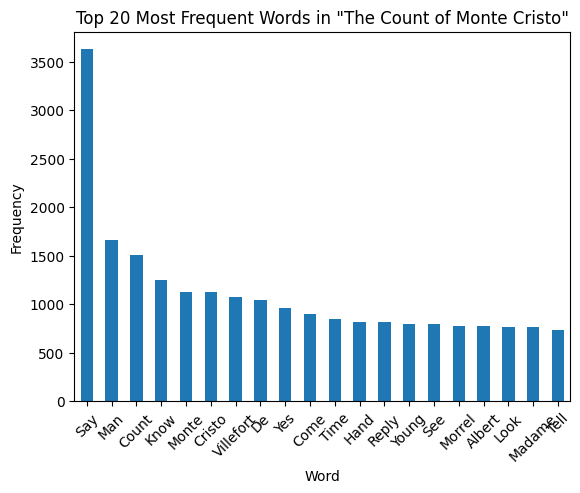

In [286]:
cristo.get_analysis()

Median Sentiment: 0.09092003922781247


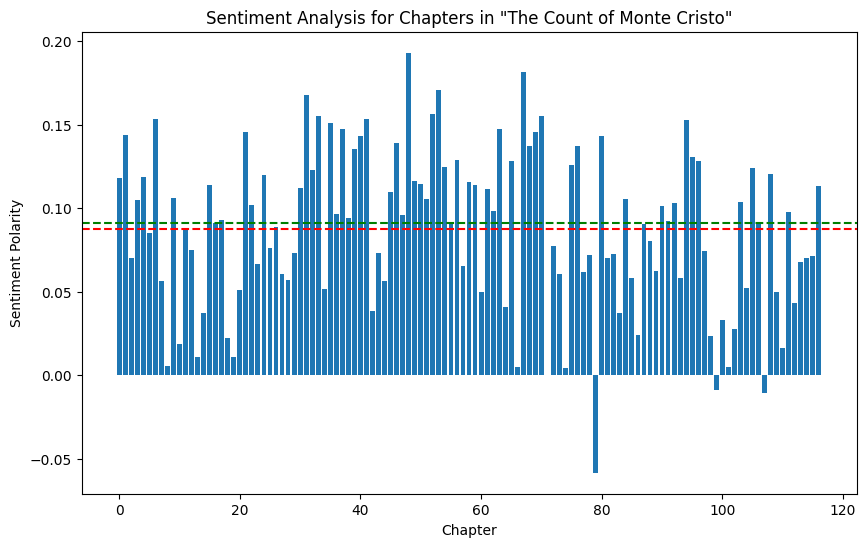

The most positive chapter was Chapter 49: 0.19305813234384667
	Tokens: new
		Polarity: 0.13636363636363635
		Subjectivity: 0.45454545454545453

	Tokens: old
		Polarity: 0.1
		Subjectivity: 0.2

	Tokens: no, other
		Polarity: 0.0625
		Subjectivity: 0.375

	Tokens: very
		Polarity: 0.2
		Subjectivity: 0.3

	Tokens: enjoyed
		Polarity: 0.5
		Subjectivity: 0.7

	Tokens: bright
		Polarity: 0.7000000000000001
		Subjectivity: 0.7999999999999999

	Tokens: pure
		Polarity: 0.21428571428571427
		Subjectivity: 0.5

	Tokens: happiness
		Polarity: 0.7
		Subjectivity: 0.2

	Tokens: deadly
		Polarity: -0.2
		Subjectivity: 0.4

	Tokens: whole
		Polarity: 0.2
		Subjectivity: 0.4

	Tokens: joy
		Polarity: 0.8
		Subjectivity: 0.2

	Tokens: back
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: least
		Polarity: -0.3
		Subjectivity: 0.4

	Tokens: brief
		Polarity: 0.0
		Subjectivity: 0.3333333333333333

	Tokens: unusual
		Polarity: 0.2
		Subjectivity: 1.0

	Tokens: ordinarily
		Polarity: -0.25
		Subjectivity:

In [287]:
cristo.chapter_analysis()
books.append(cristo)

### Les Mis

In [288]:
with open('data\Les_Misérables.txt', 'r', encoding='UTF-8') as file:
    
    # Remove the footnotes
    book_text = file.read().split('\nBOOK FIRST—A JUST MAN')[1]
    les_mis = Book('Les Miserables', book_text)

chapter_markers = r'\nCHAPTER .+'

In [289]:
les_mis.split_into_chapters(chapter_markers)

Number of chapters: 365


In [290]:
les_mis.do_nlp(nlp)

c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'blob' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'polarity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'subjectivity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:86: UserWarning: [W101] Skipping Doc custom extension 'assessments' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)


In [291]:
les_mis.chapter_nlp(nlp)

In [292]:
les_mis.blobify()

Blobby Statistics for Les Miserables
Whole Text Polarity:			0.07789551840070243
Whole Text Subjectivity:		0.4942620910458098



Basic Statistics for Les Miserables:
	Total Tokens:			737600
	Unique Words:			409754
	Average Sentence Length:	23.274746773531916
	Average Sentence Polarity:	0.04574833422707614
	Average Sentence Subjectivity:	0.2945785436825488

Sentence with highest polarity (1.0):
He was perfectly at home in the thatched cottage and in the
mountains.

	Tokens: perfectly
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
In the frightful
meditation into which its presence casts the soul the scaffold appears
in terrible guise, and as though taking part in what is going on.

	Tokens: terrible
		Polarity: -1.0
		Subjectivity: 1.0



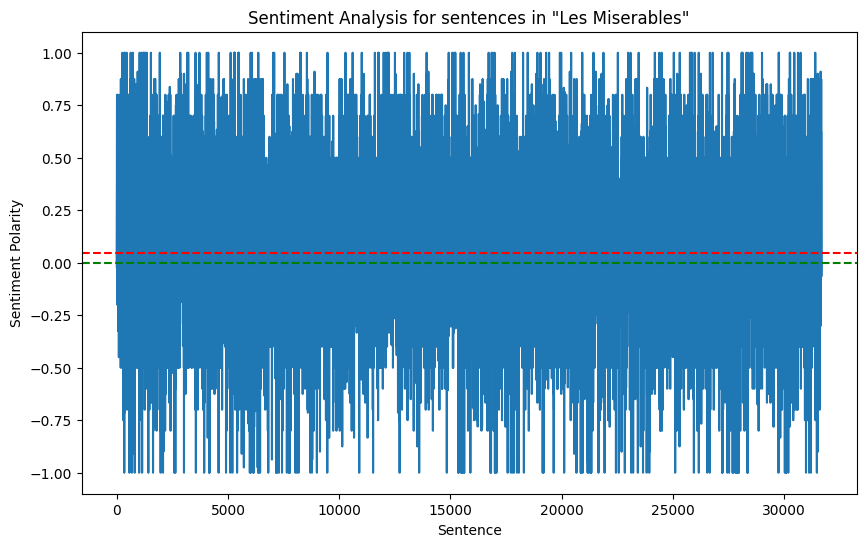

<Figure size 1000x600 with 0 Axes>

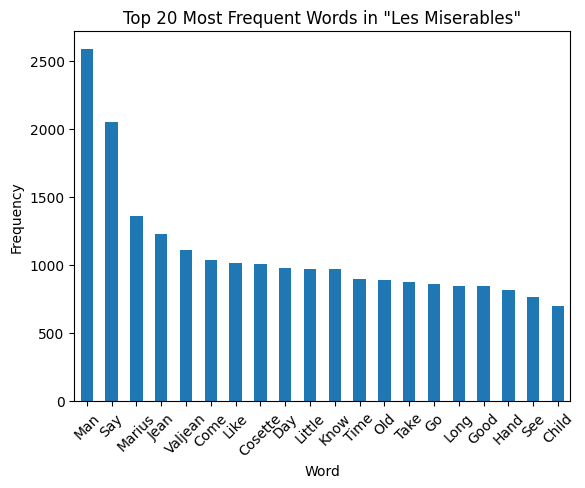

In [293]:
les_mis.get_analysis()

Median Sentiment: 0.07121437590187592


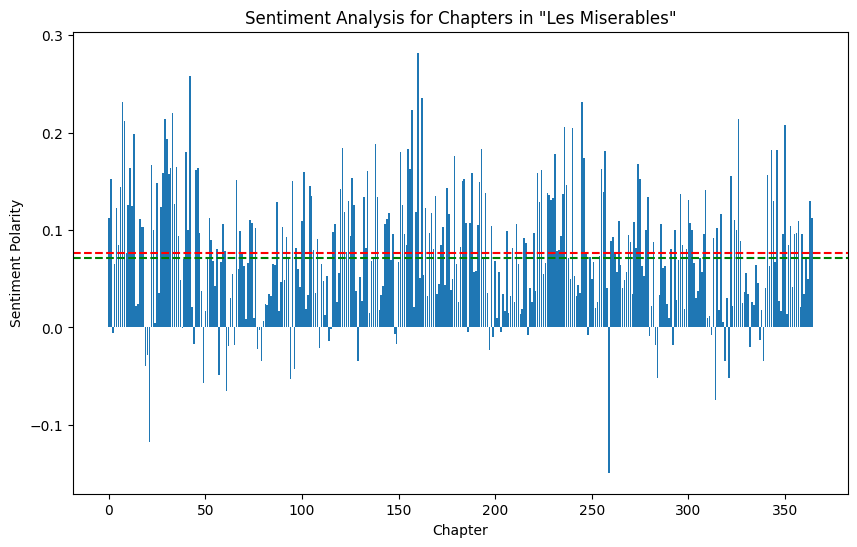

The most positive chapter was Chapter 161: 0.2821018062397373
	Tokens: vast
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: very
		Polarity: 0.2
		Subjectivity: 0.3

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: vast
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: long
		Polarity: -0.05
		Subjectivity: 0.4

	Tokens: full
		Polarity: 0.35
		Subjectivity: 0.55

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: broken
		Polarity: -0.4
		Subjectivity: 0.4

	Tokens: very, magnificent
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: long
		Polarity: -0.05
		Subjectivity: 0.4

	Tokens: old
		Polarity: 0.1
		Subjectivity: 0.2

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: elegant
		Polarity: 0.5
		Subjectivity: 1.0

	Tokens: magnificent
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: grim
		Polarity: -1.0
		Subjectivity: 1.0

	Tokens: gay
	

In [294]:
les_mis.chapter_analysis()
books.append(les_mis)

### The Secret Garden

In [295]:
with open('data\The_Secret_Garden.txt', 'r', encoding='UTF-8') as file:
    
    # Remove the footnotes
    book_text = file.read().split('THE SECRET GARDEN')[1]
    garden = Book('The Secret Garden', book_text)

chapter_markers = r'\nCHAPTER .+'


In [296]:
garden.split_into_chapters(chapter_markers)

Number of chapters: 27


In [297]:
garden.do_nlp(nlp)

In [298]:
garden.chapter_nlp(nlp)

In [299]:
garden.blobify()

Blobby Statistics for The Secret Garden
Whole Text Polarity:			0.0866785734564911
Whole Text Subjectivity:		0.5013226018862033



Basic Statistics for The Secret Garden:
	Total Tokens:			106823
	Unique Words:			56493
	Average Sentence Length:	19.500365096750638
	Average Sentence Polarity:	0.055081350357218034
	Average Sentence Subjectivity:	0.29827132099361114

Sentence with highest polarity (1.0):
The house was
perfectly still.

	Tokens: perfectly
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
she said, because to call a native a pig
is the worst insult of all.



	Tokens: worst
		Polarity: -1.0
		Subjectivity: 1.0



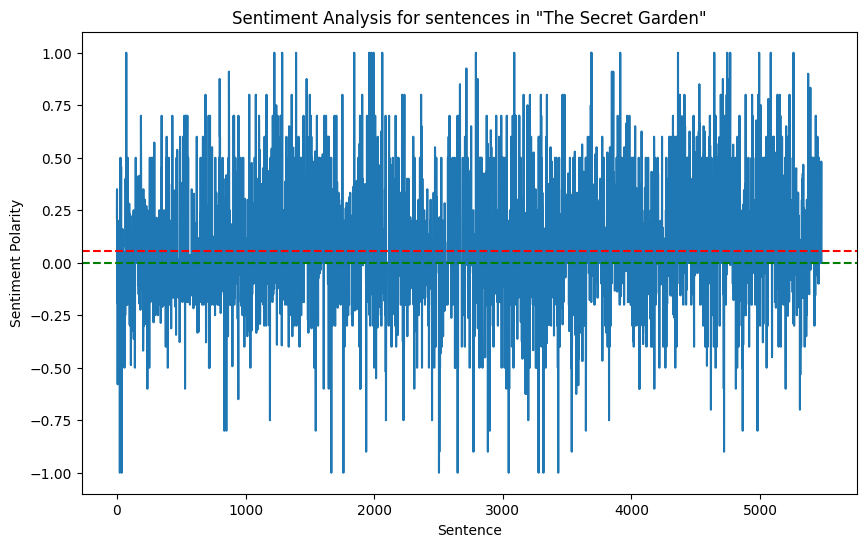

<Figure size 1000x600 with 0 Axes>

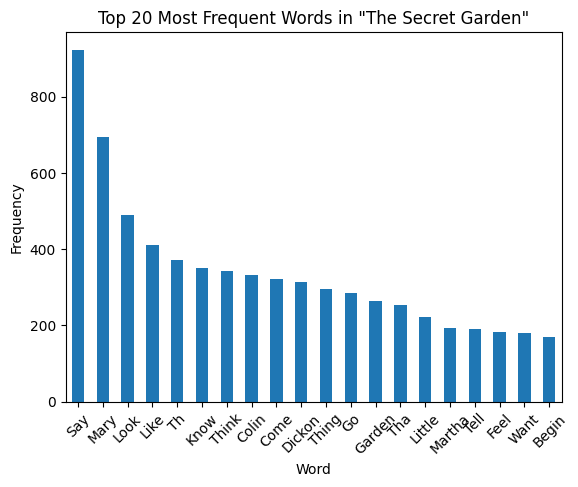

In [300]:
garden.get_analysis()

Median Sentiment: 0.07450191752691758


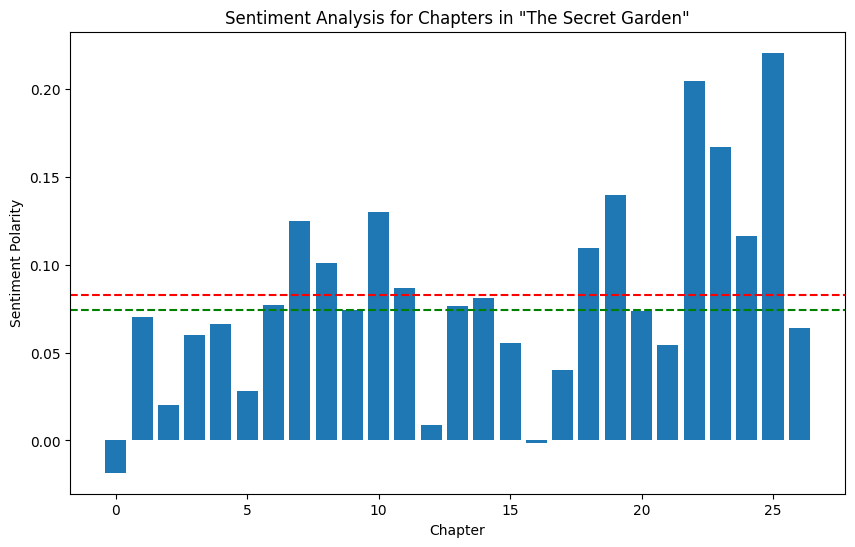

The most positive chapter was Chapter 26: 0.2208106156075262
	Tokens: magic
		Polarity: 0.5
		Subjectivity: 1.0

	Tokens: magic
		Polarity: 0.5
		Subjectivity: 1.0

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: only
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: short
		Polarity: 0.0
		Subjectivity: 0.3

	Tokens: very, young
		Polarity: 0.13
		Subjectivity: 0.52

	Tokens: best
		Polarity: 1.0
		Subjectivity: 0.3

	Tokens: no, other
		Polarity: 0.0625
		Subjectivity: 0.375

	Tokens: back
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: old
		Polarity: 0.1
		Subjectivity: 0.2

	Tokens: fixed
		Polarity: 0.1
		Subjectivity: 0.2

	Tokens: critical
		Polarity: 0.0
		Subjectivity: 0.8

	Tokens: much
		Polarity: 0.2
		Subjectivity: 0.2

	Tokens: interested
		Polarity: 0.25
		Subjectivity: 0.5

	Tokens: sharp
		Polarity: -0.125
		Subjectivity: 0.75

	Tokens: hollow
		Polarity: -0.1
		Subjectivity: 0.05

	Tokens: filled
		Polarity: 0.4
		Subjectivity: 0.9

	Tokens: light
		Polarity:

In [301]:
garden.chapter_analysis()
books.append(garden)

In [304]:
with open('data\Treasure_Island.txt', 'r', encoding='UTF-8') as file:
    
    # Remove the footnotes
    book_text = file.read().split('\nTREASURE ISLAND\n\n\n')[1]
    treasure = Book('Treasure Island', book_text)

chapter_markers = r'\n\d+\n\n'


In [306]:
treasure.split_into_chapters(chapter_markers)

Number of chapters: 34


In [307]:
treasure.do_nlp(nlp)

In [308]:
treasure.chapter_nlp(nlp)

In [309]:
treasure.blobify()

Blobby Statistics for Treasure Island
Whole Text Polarity:			0.07396055277222874
Whole Text Subjectivity:		0.4738423381378094



Basic Statistics for Treasure Island:
	Total Tokens:			90006
	Unique Words:			46994
	Average Sentence Length:	27.10207768744354
	Average Sentence Polarity:	0.05663759369643552
	Average Sentence Subjectivity:	0.3258300294190588

Sentence with highest polarity (1.0):
In three weeks’ time--three
weeks!--two weeks--ten days--we’ll have the best ship, sir, and the
choicest crew in England.

	Tokens: best
		Polarity: 1.0
		Subjectivity: 0.3

Sentence with lowest polarity (-1.0):
To see him leap and run and pursue me over hedge and
ditch was the worst of nightmares.

	Tokens: worst
		Polarity: -1.0
		Subjectivity: 1.0



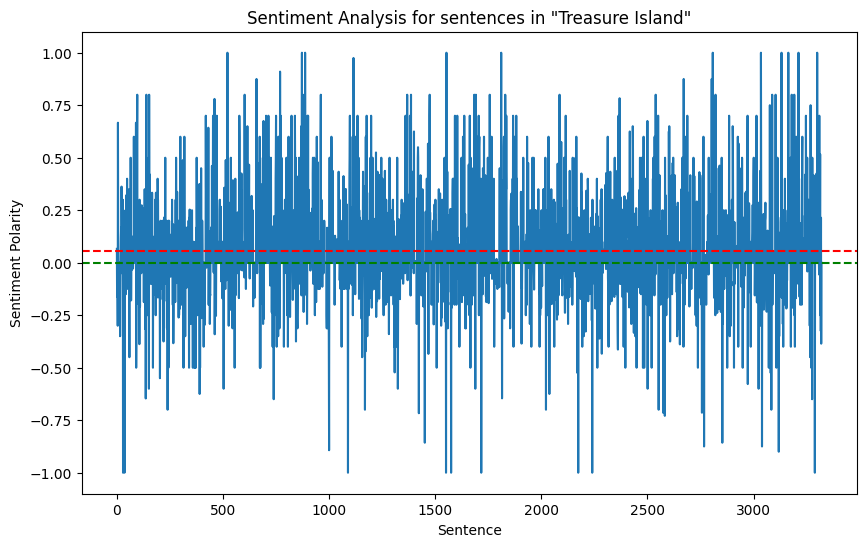

<Figure size 1000x600 with 0 Axes>

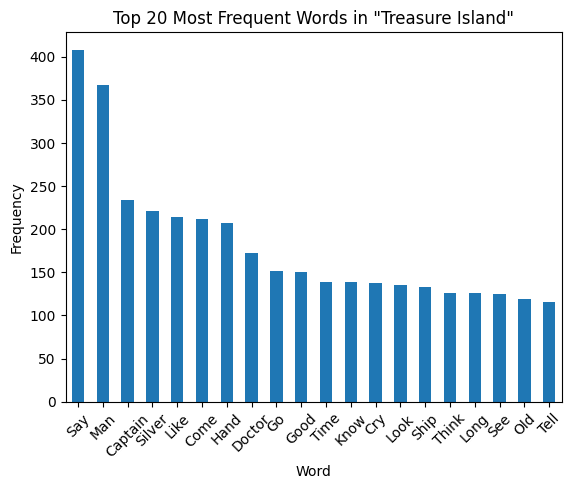

In [310]:
treasure.get_analysis()

Median Sentiment: 0.0785041199040464


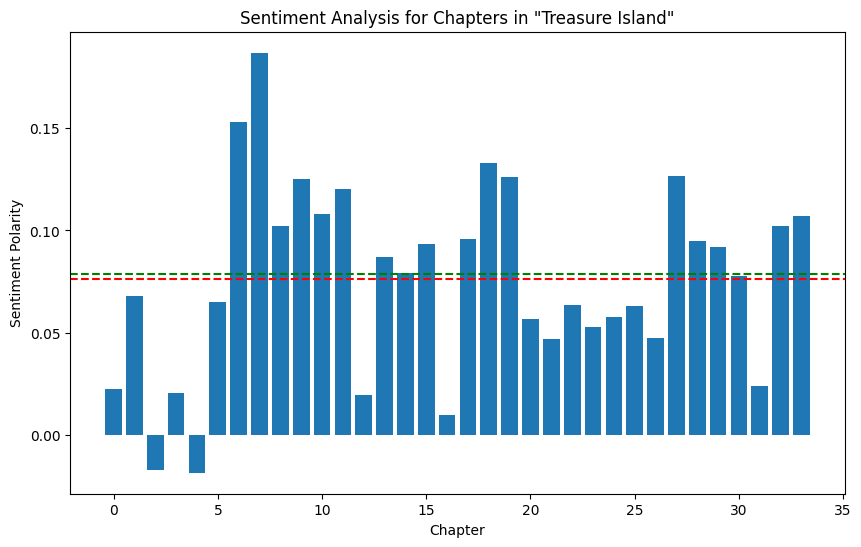

The most positive chapter was Chapter 8: 0.1867603474381643
	Tokens: easily
		Polarity: 0.43333333333333335
		Subjectivity: 0.8333333333333334

	Tokens: following
		Polarity: 0.0
		Subjectivity: 0.1

	Tokens: bright
		Polarity: 0.7000000000000001
		Subjectivity: 0.7999999999999999

	Tokens: little
		Polarity: -0.1875
		Subjectivity: 0.5

	Tokens: large
		Polarity: 0.21428571428571427
		Subjectivity: 0.42857142857142855

	Tokens: more
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: bright
		Polarity: 0.7000000000000001
		Subjectivity: 0.7999999999999999

	Tokens: enough
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: little
		Polarity: -0.1875
		Subjectivity: 0.5

	Tokens: newly
		Polarity: 0.13636363636363635
		Subjectivity: 0.45454545454545453

	Tokens: red
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: cleanly
		Polarity: 0.3666666666666667
		Subjectivity: 0.7000000000000001

	Tokens: open
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: l

In [311]:
treasure.chapter_analysis()
books.append(treasure)

## Persuasion

In [312]:
with open('data\Persuasion.txt', 'r', encoding='UTF-8') as file:
    
    # Remove the footnotes
    book_text = file.read().split('V.\n\n\n\n\n')[1]
    persuasion = Book('Persuasion', book_text)

chapter_markers = r'\nCHAPTER .+'


In [313]:
persuasion.split_into_chapters(chapter_markers)

Number of chapters: 23


In [314]:
persuasion.do_nlp(nlp)

In [315]:
persuasion.chapter_nlp(nlp)

In [316]:
persuasion.blobify()

Blobby Statistics for Persuasion
Whole Text Polarity:			0.14848569871328735
Whole Text Subjectivity:		0.5224485977268671



Basic Statistics for Persuasion:
	Total Tokens:			105672
	Unique Words:			53328
	Average Sentence Length:	31.46873138773079
	Average Sentence Polarity:	0.10649660304728487
	Average Sentence Subjectivity:	0.38827663029883364

Sentence with highest polarity (1.0):
The hint was immediately taken up by Mr Shepherd,
whose interest was involved in the reality of Sir Walter’s retrenching,
and who was perfectly persuaded that nothing would be done without a
change of abode.

	Tokens: perfectly
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
There will be nothing singular in his case; and
it is singularity which often makes the worst part of our suffering, as
it always does of our conduct.

	Tokens: worst
		Polarity: -1.0
		Subjectivity: 1.0



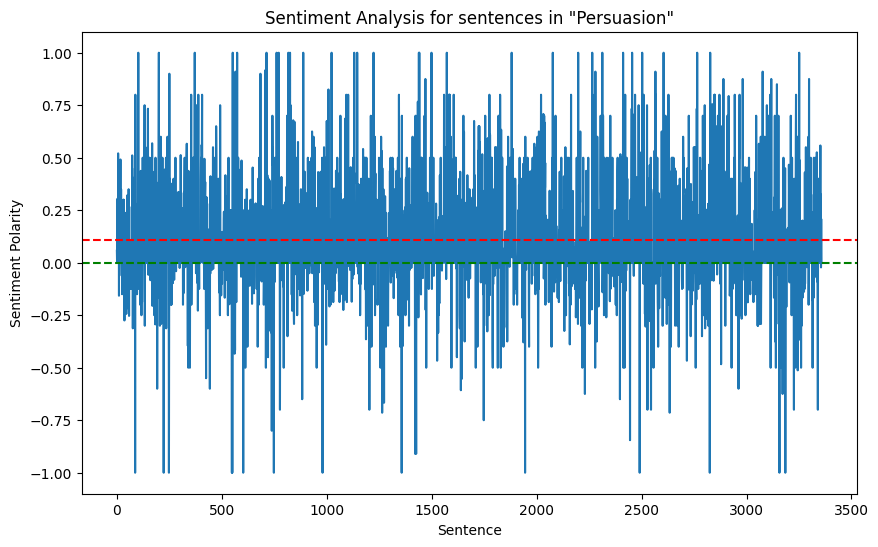

<Figure size 1000x600 with 0 Axes>

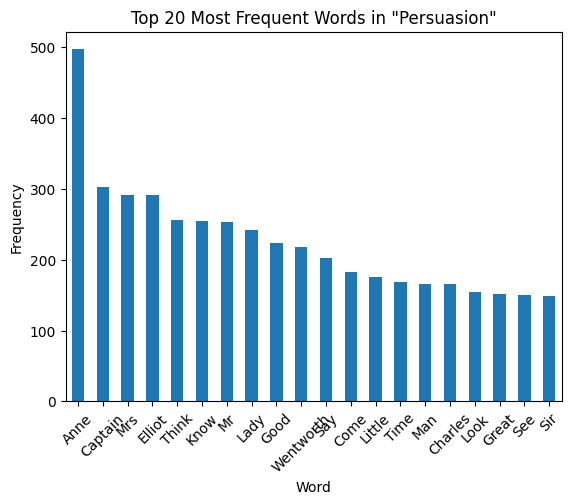

In [317]:
persuasion.get_analysis()

Median Sentiment: 0.14755788264598838


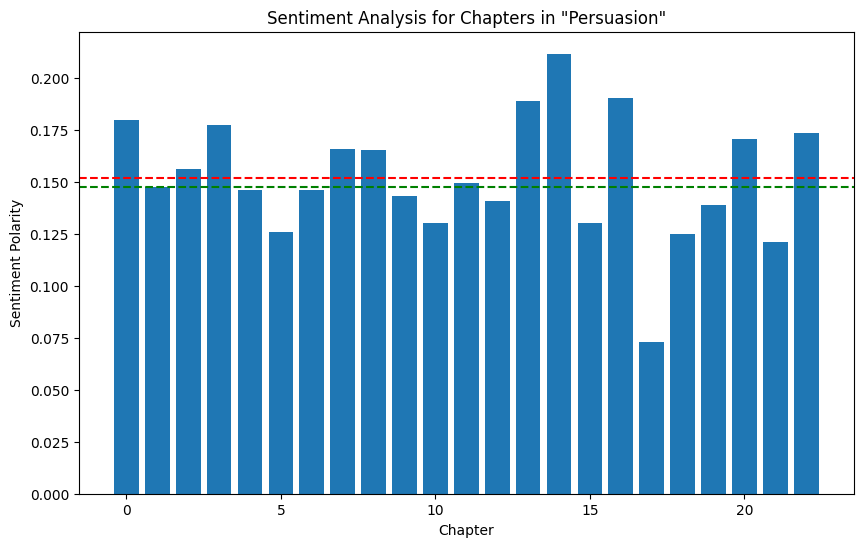

The most positive chapter was Chapter 15: 0.21179845360400906
	Tokens: more
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: love
		Polarity: 0.5
		Subjectivity: 0.6

	Tokens: love
		Polarity: 0.5
		Subjectivity: 0.6

	Tokens: very, far
		Polarity: 0.13
		Subjectivity: 1.0

	Tokens: easy
		Polarity: 0.43333333333333335
		Subjectivity: 0.8333333333333334

	Tokens: few
		Polarity: -0.2
		Subjectivity: 0.1

	Tokens: down
		Polarity: -0.15555555555555559
		Subjectivity: 0.2888888888888889

	Tokens: next
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: decent
		Polarity: 0.16666666666666666
		Subjectivity: 0.6666666666666666

	Tokens: full
		Polarity: 0.35
		Subjectivity: 0.55

	Tokens: only
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: useful
		Polarity: 0.3
		Subjectivity: 0.0

	Tokens: acquainted
		Polarity: 0.5
		Subjectivity: 0.6

	Tokens: beautiful
		Polarity: 0.85
		Subjectivity: 1.0

	Tokens: fine
		Polarity: 0.4166666666666667
		Subjectivity: 0.5

	Tokens: real
		Polarity: 0.2
		Subjecti

In [318]:
persuasion.chapter_analysis()
books.append(persuasion)

## Similarity Matrix

In [319]:
checker2 = SimilarityChecker(books)
checker2.calculate_all_similarities()

c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\similarity.py:12: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  first_sentence.similarity(second_sentence)


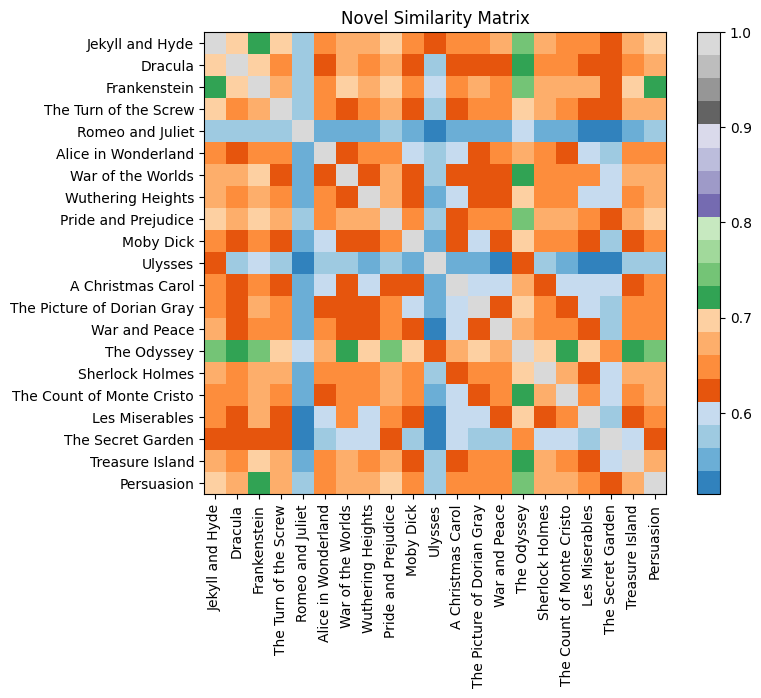

In [320]:
checker2.display_matrix()